## GLM for events

In [2]:
## Load required modules
import warnings, sys, os ## system
if not sys.warnoptions:
    warnings.simplefilter("ignore") # ignore warnings

import re
import os
import glob
from datetime import datetime    
import time
import copy
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from itertools import product, combinations
import multiprocessing as mp


from bids import BIDSLayout, BIDSValidator

from nilearn.maskers import NiftiMasker
from nilearn import plotting, image
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.image import concat_imgs, mean_img
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [4]:
# Load files 
story_dir = '/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA'
May_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'

In [24]:
#Subject check 
sub_sm = np.arange(1,34)
sub_sm_exclude = [0, 8, 25] #exclude 9 & 26
subjects = np.delete(sub_sm, sub_sm_exclude)
#print(subject)
print(subjects)

[ 2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 27
 28 29 30 31 32 33]


In [26]:
# load story sequence 
import scipy.io as sio

all_story = {}
# Load May Data
for sub in subjects:
    #print(sub)
    mat = sio.loadmat(glob.glob(os.path.join(story_dir, 'fMRItdsgn', 'fMRI_May', f'sub-{sub}_*.mat'))[0])
    story = []
    for i in np.arange(0,4):
        temp = mat['subj'][0][0][7][0][i][0]
        if temp == 'Blind Date':
            temp = 'BlindDate'
        elif temp == 'Runningman':
            temp = 'RunningMan'
        elif temp == 'neighbors':
            temp = 'Neighbors'
        story = np.append(story, temp)
    #all_story[str(int(sub)+8)] = story
    all_story[sub] = story
#Fix story sequence
#story_sequece = all_story[]
#story_sequece

In [81]:
all_story[sub]

array(['Neighbors', 'RunningMan', 'BlindDate', 'Dream'], dtype='<U32')

# Practice: first level analysis for sub-18 

In [155]:
encoding_files

['/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2024/sub-33_task-encoding_run-1_4scNsm.nii.gz',
 '/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2024/sub-33_task-encoding_run-2_4scNsm.nii.gz']

In [154]:
#load BOLD Volume
encoding_files = glob.glob(os.path.join(May_dir,'denoised', 'denoised_2024', f'sub-*{sub}_task-encoding_run-*_4scNsm.nii.gz'))

func_imgs = {}
for run in np.arange(0,2):
    
    func_imgs[run] = image.load_img(encoding_files[run]) 
    
#print(func_imgs[run])

# Display the shape of the image
print('Image shape:', func_imgs[run].shape)

Image shape: (91, 109, 91, 477)


In [116]:
eb_onset = {'run':[15,40,68,85,147], 'dream':[15,40,77,132], 'nei':[15,33,65, 81, 107, 140], 'blind':[15, 55, 90, 131, 157]}
eb_offset = {'run':[40,68,85,147, 180], 'dream':[40,77,132,165], 'nei':[33,65, 81, 107, 140, 180], 'blind':[55, 90, 131, 157, 180]}

# Data Load & Trimming 
onset = {'Dream1': [0, 165, 345, 525], 'Dream2': [0, 180, 345, 525], 'Dream3': [0, 180, 360, 525], 'Dream4': [0, 180, 345, 540]}
storyName = {'RunningMan': 'run', 'BlindDate': 'blind', 'Dream':'dream', 'Neighbors':'nei'}

sequence = np.where(all_story[sub]=='Dream')[0][0]
cond = 'Dream'+str(int(sequence)+1)

sub = 18

isi = 15  # Inter-stimulus interval between events in seconds
tr = 1.5  # Repetition time in seconds
start_time = 0  # Start time for the first event

# Generate the events data frame
events_list = []

for story in np.arange(0,4):    
    thisStory = storyName[all_story[sub][story]] 
    duration = [ai - bi for ai, bi in zip(eb_offset[thisStory], eb_onset[thisStory])]
    
    for event in range(len(eb_onset[thisStory])):
        events_list.append({
            'onset': onset[cond][story] + eb_onset[thisStory][event],
            'duration': duration[event],
            'trial_type': f'{thisStory}{event}'
        })
        #start_time += event_duration

# Convert to DataFrame
events = pd.DataFrame(events_list)

print(events)


    onset  duration trial_type
0      15        40     blind0
1      55        35     blind1
2      90        41     blind2
3     131        26     blind3
4     157        23     blind4
5     195        25     dream0
6     220        37     dream1
7     257        55     dream2
8     312        33     dream3
9     360        18       nei0
10    378        32       nei1
11    410        16       nei2
12    426        26       nei3
13    452        33       nei4
14    485        40       nei5
15    540        25       run0
16    565        28       run1
17    593        17       run2
18    610        62       run3
19    672        33       run4


In [117]:
# Calculate the total number of scans
tr = 1.5  # Repetition time in seconds
dummy = 9 
total_time = events['onset'].iloc[-1] +  events['duration'].iloc[-1] + dummy  # Time after last event ends
n_scans = int(total_time / tr)+1

# Frame times: time for each scan
frame_times = np.arange(0, n_scans * tr, tr)
print(total_time, n_scans)
print(frame_times.shape)
frame_times

714 477
(477,)


array([  0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,  12. ,
        13.5,  15. ,  16.5,  18. ,  19.5,  21. ,  22.5,  24. ,  25.5,
        27. ,  28.5,  30. ,  31.5,  33. ,  34.5,  36. ,  37.5,  39. ,
        40.5,  42. ,  43.5,  45. ,  46.5,  48. ,  49.5,  51. ,  52.5,
        54. ,  55.5,  57. ,  58.5,  60. ,  61.5,  63. ,  64.5,  66. ,
        67.5,  69. ,  70.5,  72. ,  73.5,  75. ,  76.5,  78. ,  79.5,
        81. ,  82.5,  84. ,  85.5,  87. ,  88.5,  90. ,  91.5,  93. ,
        94.5,  96. ,  97.5,  99. , 100.5, 102. , 103.5, 105. , 106.5,
       108. , 109.5, 111. , 112.5, 114. , 115.5, 117. , 118.5, 120. ,
       121.5, 123. , 124.5, 126. , 127.5, 129. , 130.5, 132. , 133.5,
       135. , 136.5, 138. , 139.5, 141. , 142.5, 144. , 145.5, 147. ,
       148.5, 150. , 151.5, 153. , 154.5, 156. , 157.5, 159. , 160.5,
       162. , 163.5, 165. , 166.5, 168. , 169.5, 171. , 172.5, 174. ,
       175.5, 177. , 178.5, 180. , 181.5, 183. , 184.5, 186. , 187.5,
       189. , 190.5,

In [ ]:
# Story variable 을 추가해야하는 걸까...? 

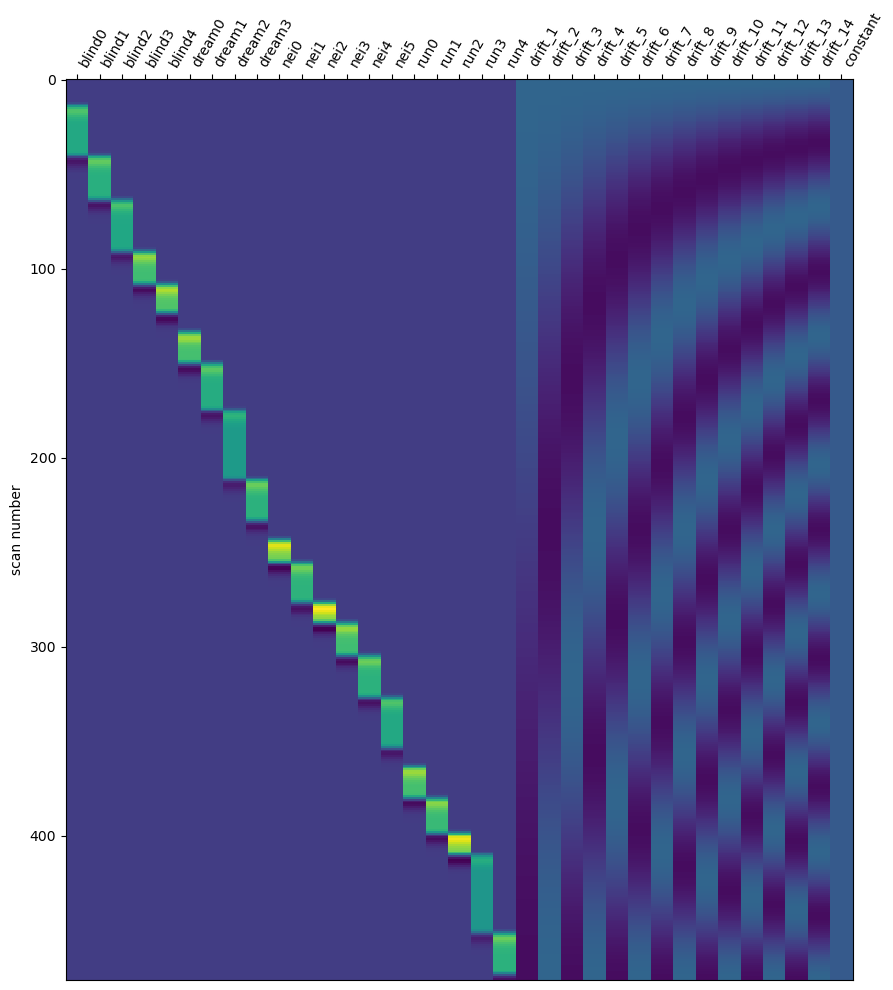

In [146]:
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    drift_model='cosine'
)

# Plot the design matrix
plot_design_matrix(design_matrix)
plt.show()

In [122]:
np.unique(events['trial_type'])

array(['blind0', 'blind1', 'blind2', 'blind3', 'blind4', 'dream0',
       'dream1', 'dream2', 'dream3', 'nei0', 'nei1', 'nei2', 'nei3',
       'nei4', 'nei5', 'run0', 'run1', 'run2', 'run3', 'run4'],
      dtype=object)

In [159]:
# Fit the GLM
output_dir = os.path.join(May_dir,'analysis', 'betas') 

betas = [] 
for i in range(0,2):
    glm = FirstLevelModel(t_r=1.22, hrf_model='glover', drift_model='cosine')
    glm = glm.fit(func_imgs[i], design_matrices=design_matrix)

    # Compute and visualize beta maps
    for j, label in enumerate(np.unique(events['trial_type'])):
        beta_map = glm.compute_contrast(label)
        #plotting.plot_stat_map(beta_map, title=label, display_mode='z', threshold=2.3, cut_coords=5)
        
        beta_img_path = os.path.join(output_dir, f"sub-{sub}_task-encoding_run-0{i+1}_event-{label}_beta_image.nii.gz")
        nib.save(beta_map, beta_img_path)


## All subjects GLM 

2
event_size (20, 3)
desingMatrix_size (477, 35)
Load func_img files: /mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2024/sub-02_task-encoding_run-1_4scNsm.nii.gz
Image shape: (91, 109, 91, 477)
Load func_img files: /mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2024/sub-02_task-encoding_run-2_4scNsm.nii.gz
Image shape: (91, 109, 91, 477)
3
event_size (20, 3)
desingMatrix_size (477, 35)
Load func_img files: /mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2024/sub-03_task-encoding_run-1_4scNsm.nii.gz
Image shape: (91, 109, 91, 477)
Load func_img files: /mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2024/sub-03_task-encoding_run-2_4scNsm.nii.gz
Image shape: (91, 109, 91, 477)
4
event_size (20, 3)
desingMatrix_size (477, 35)
Load func_img files: /mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2024/sub-04_task-encoding_run-1_4scNsm.nii.gz
Image shape: (91, 109, 91, 477)
Load func_img files: /mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2024/su

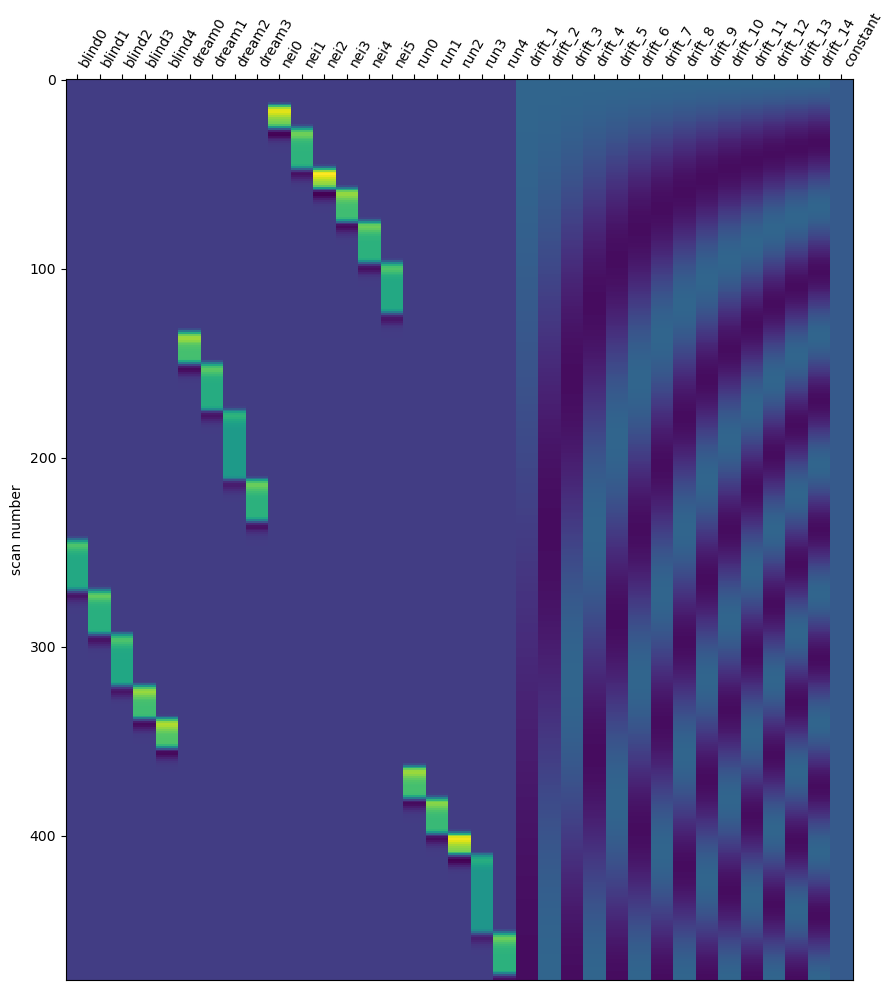

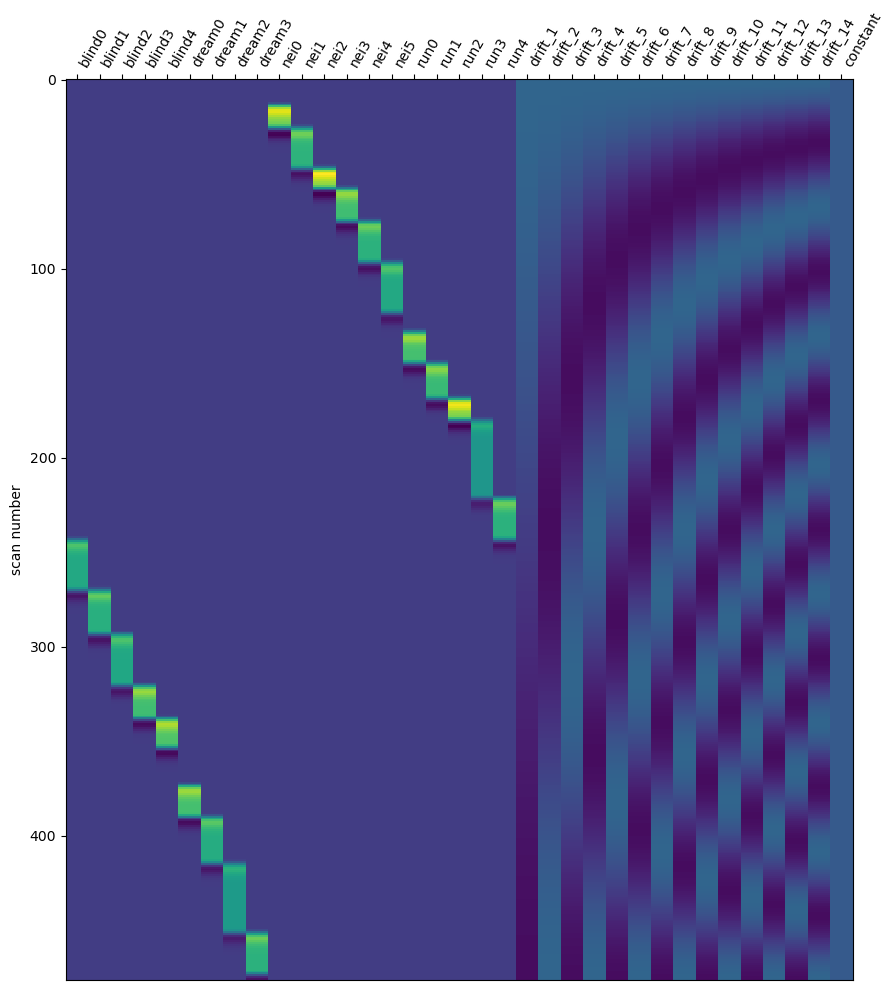

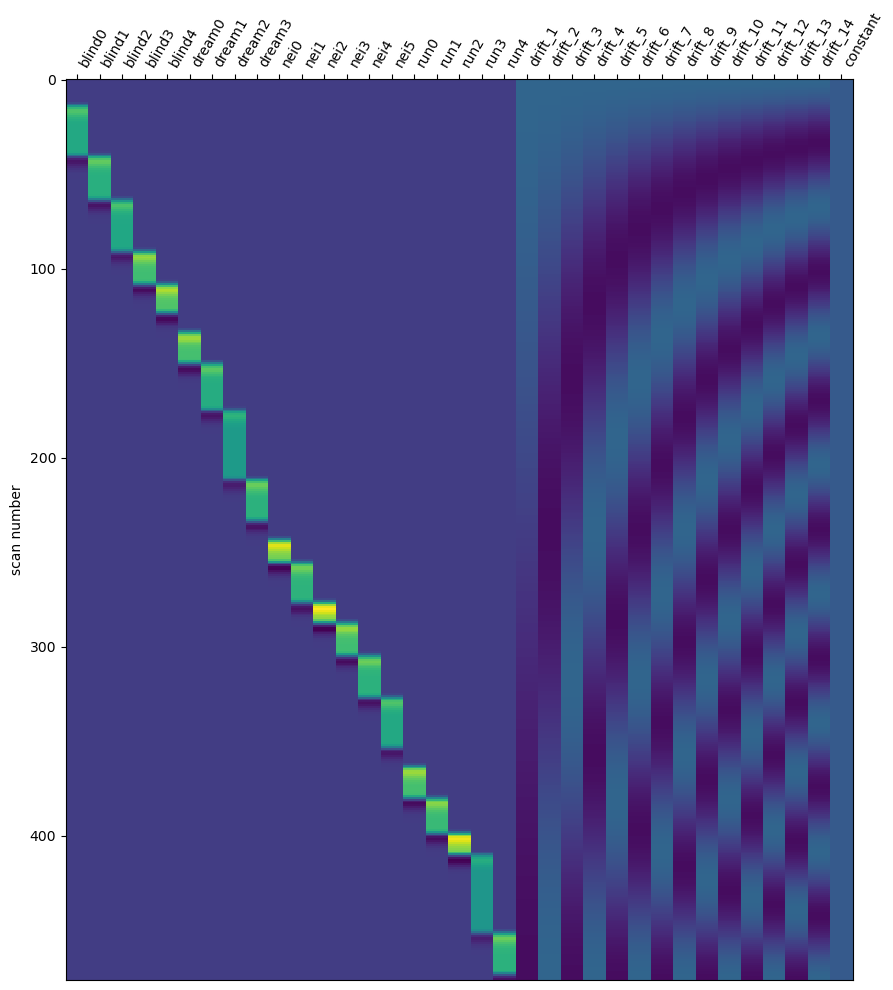

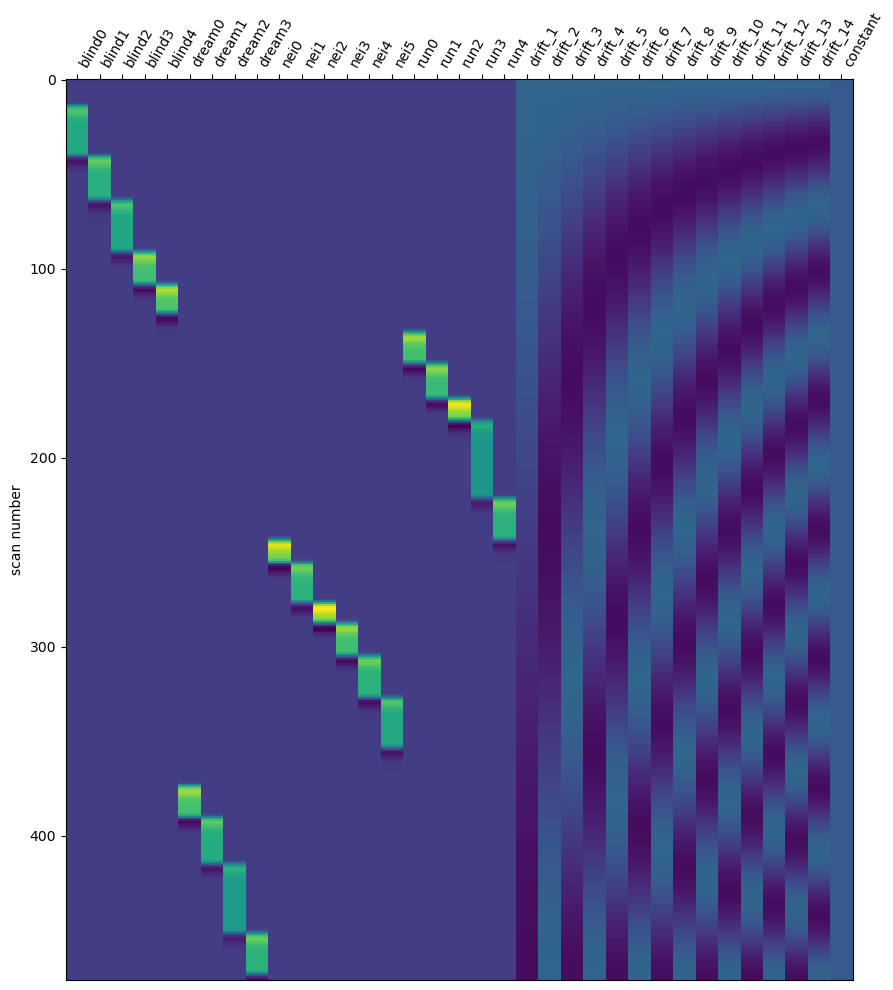

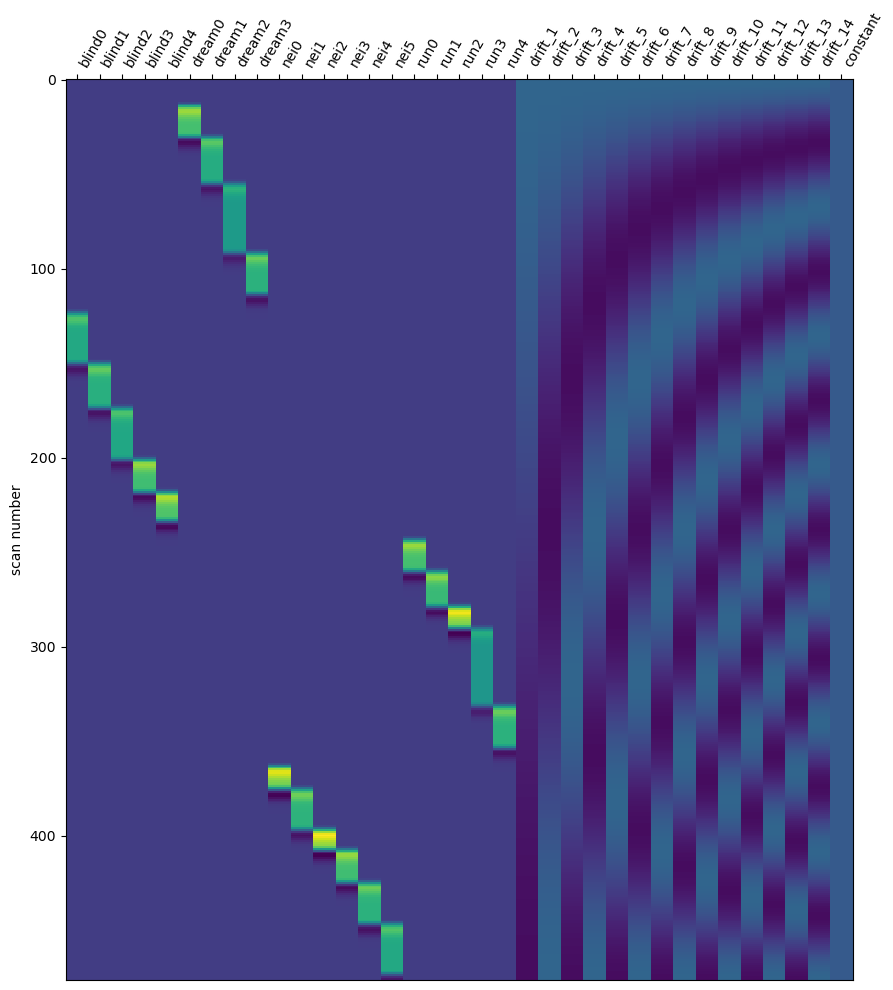

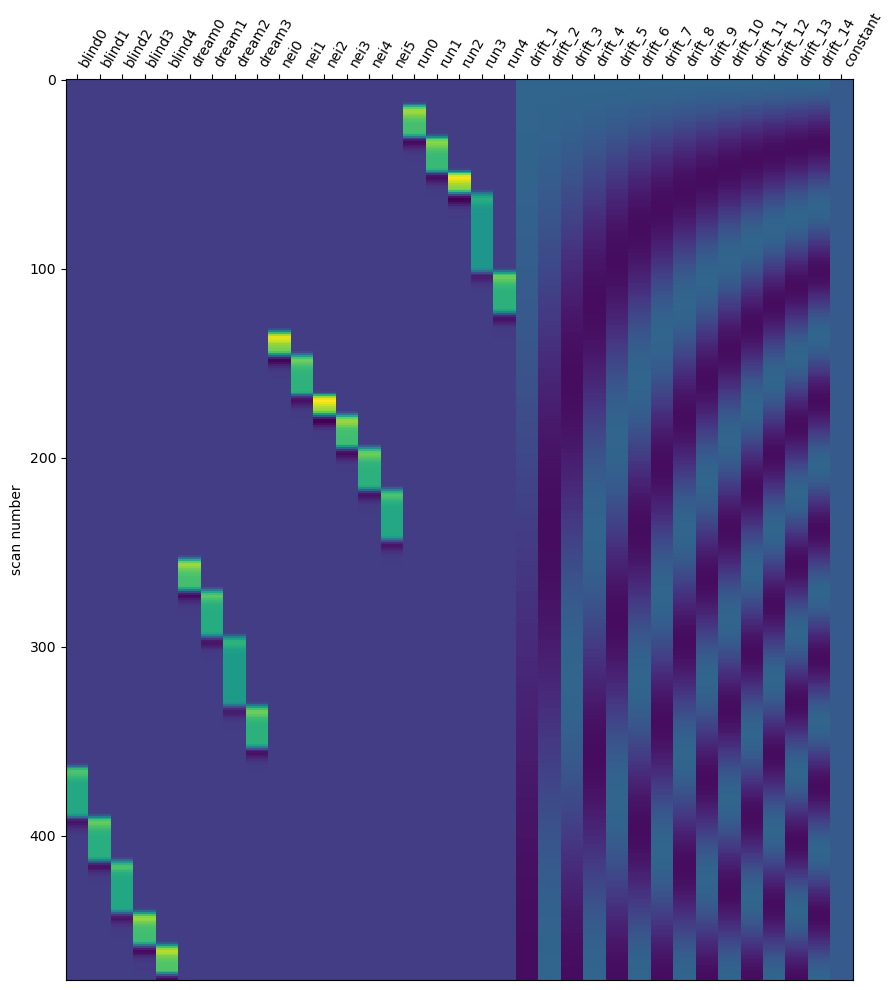

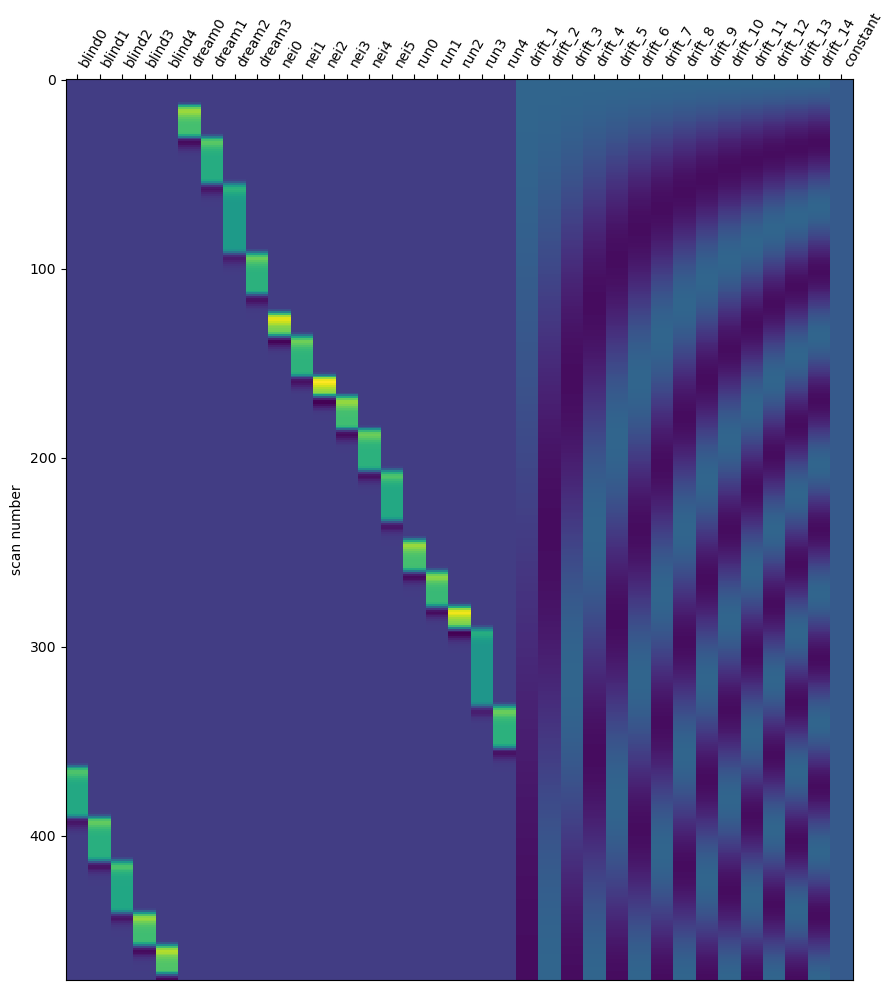

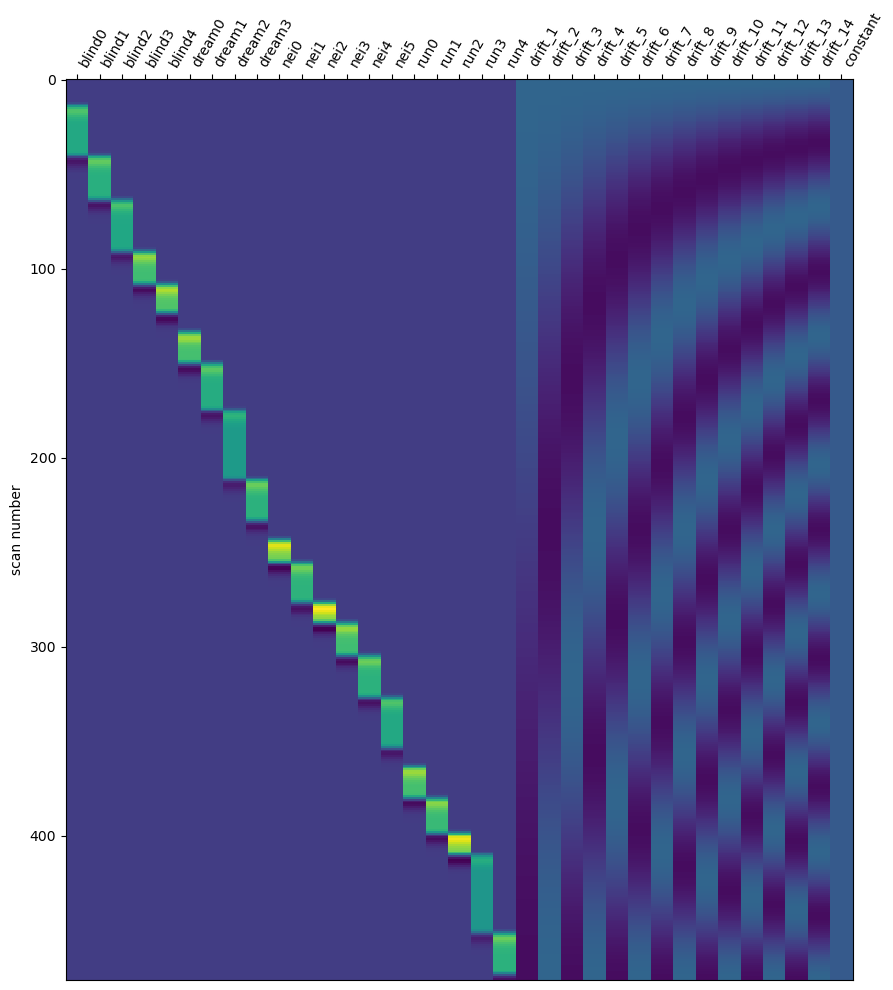

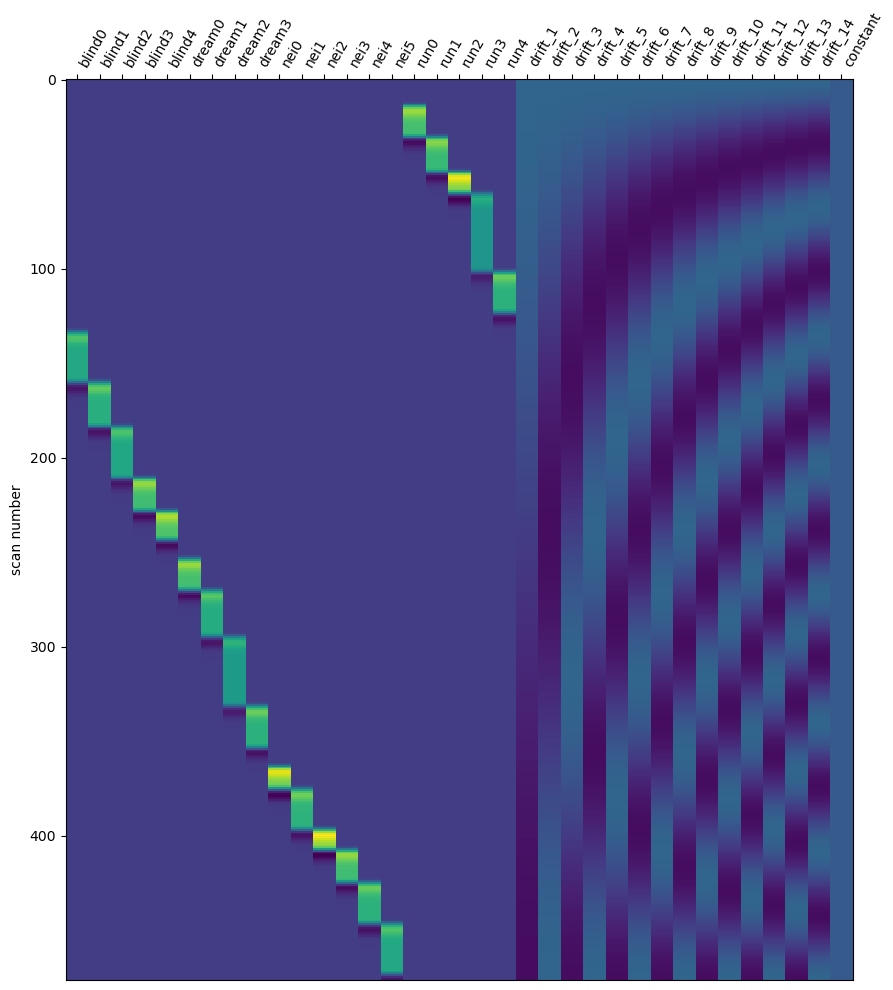

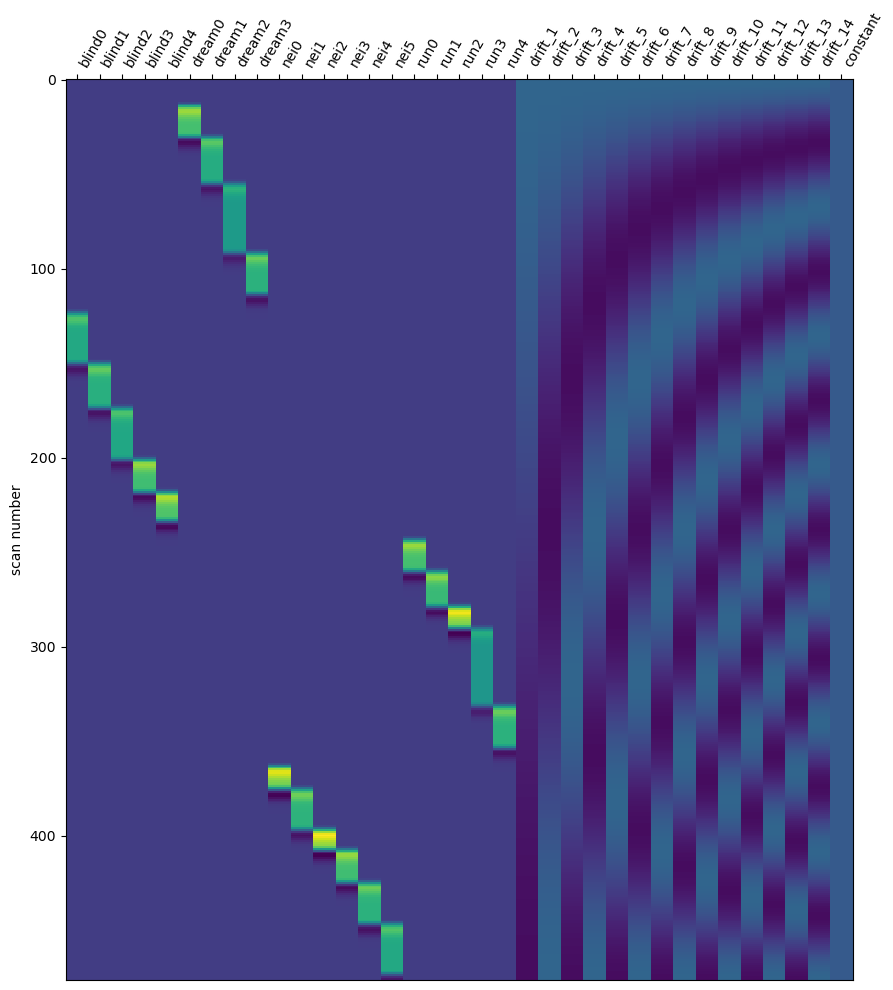

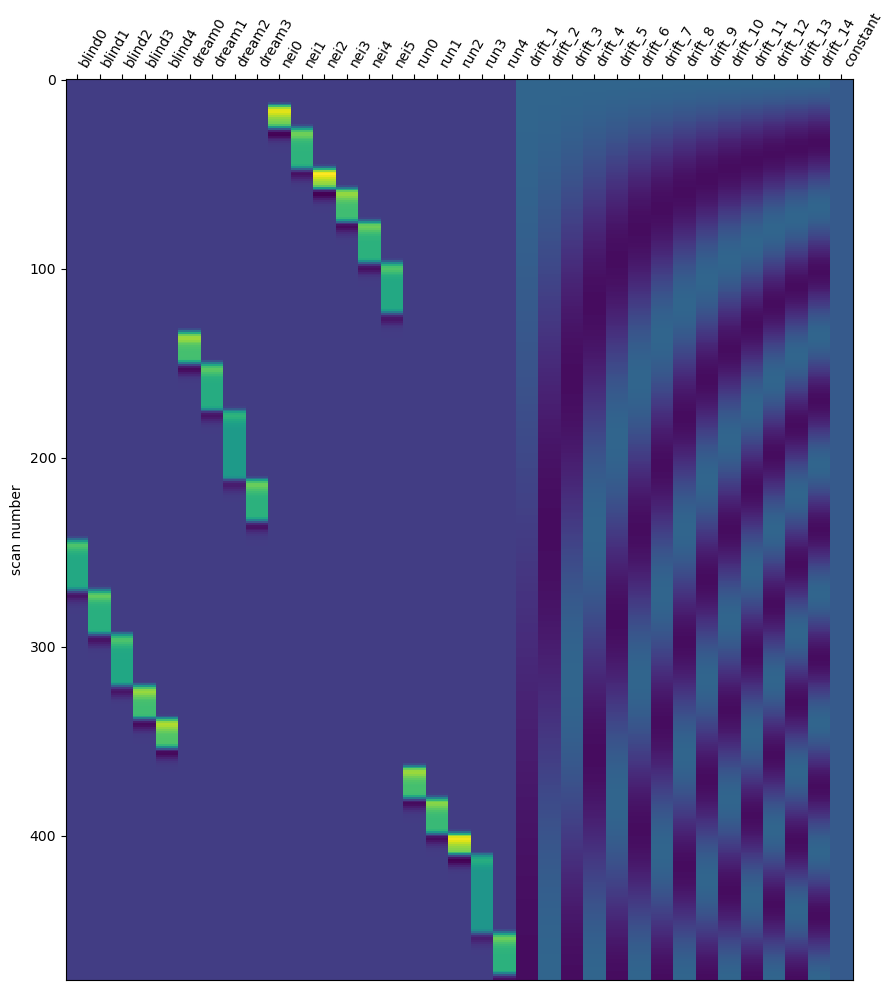

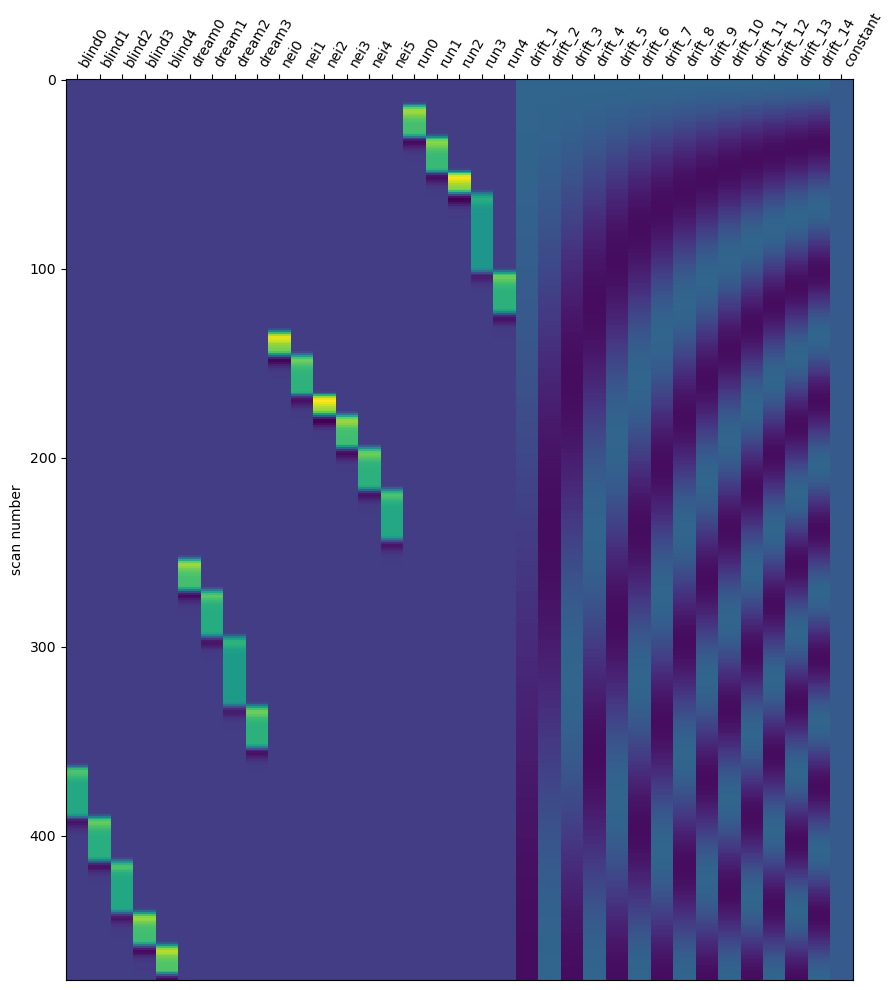

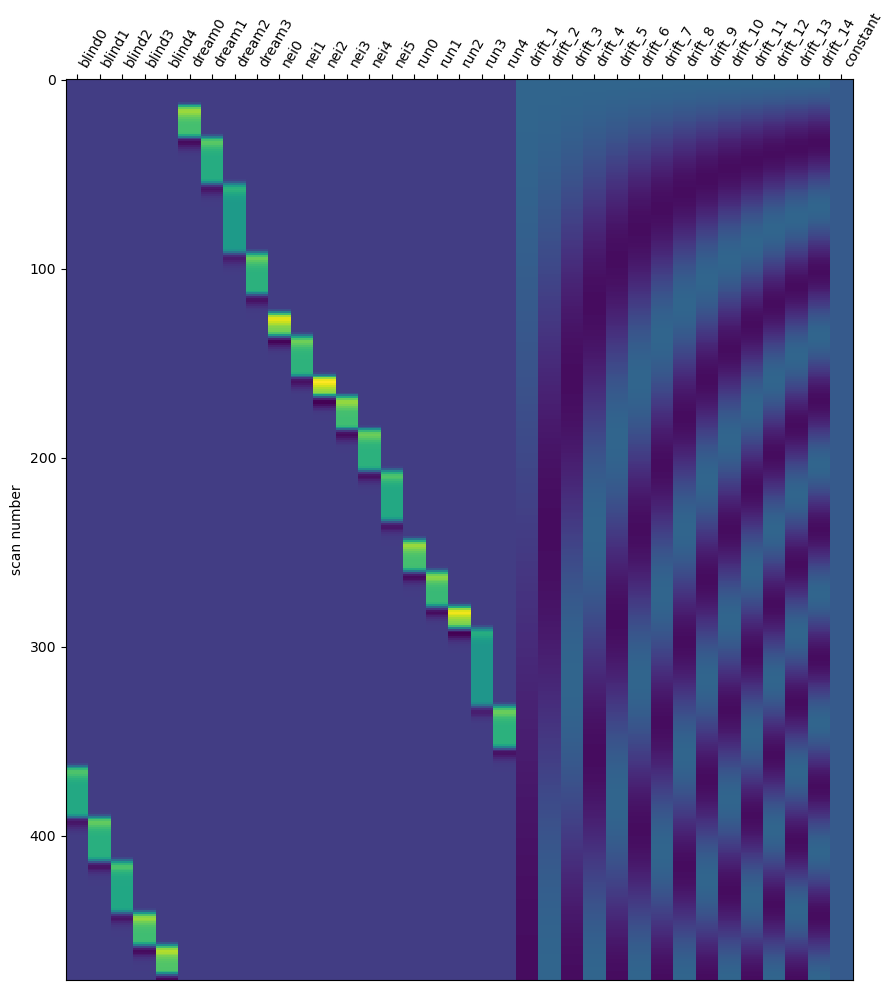

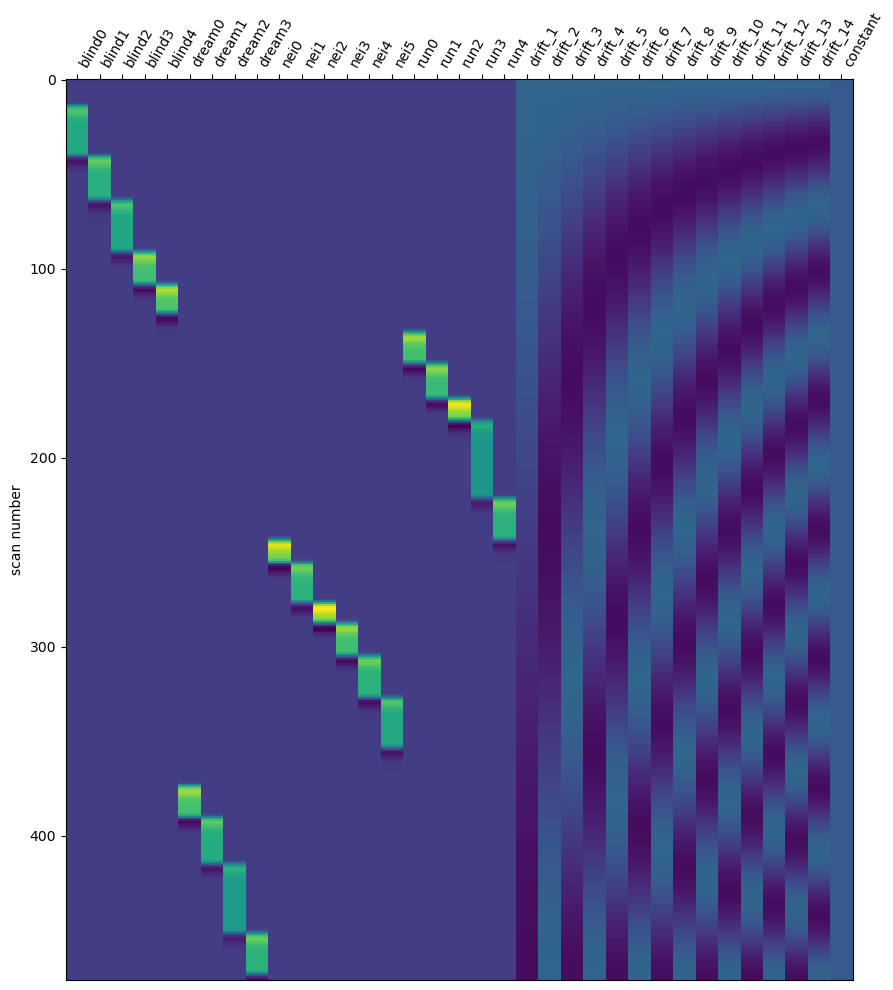

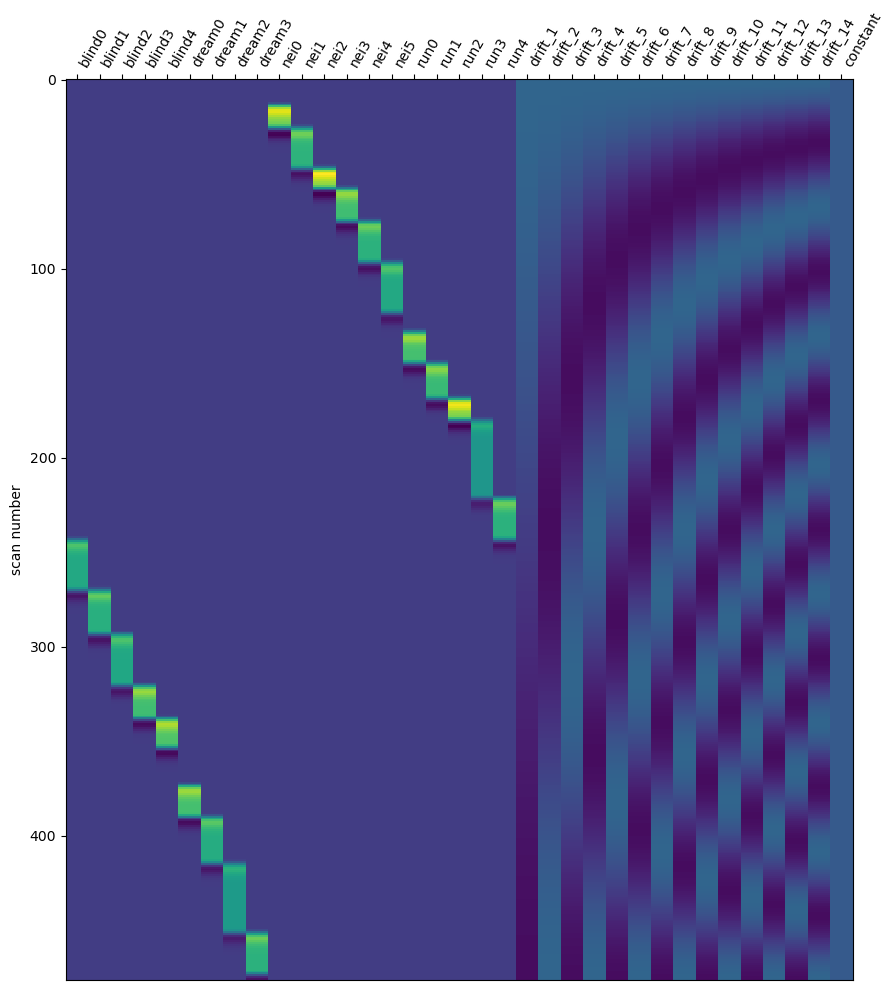

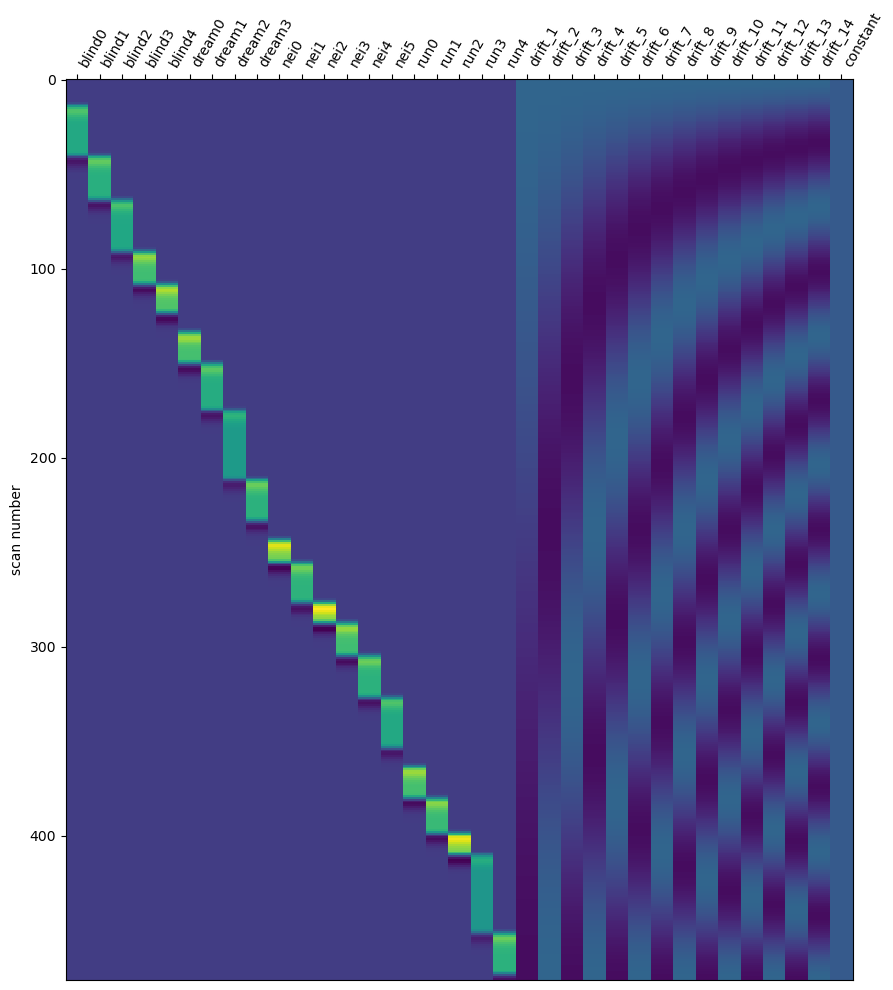

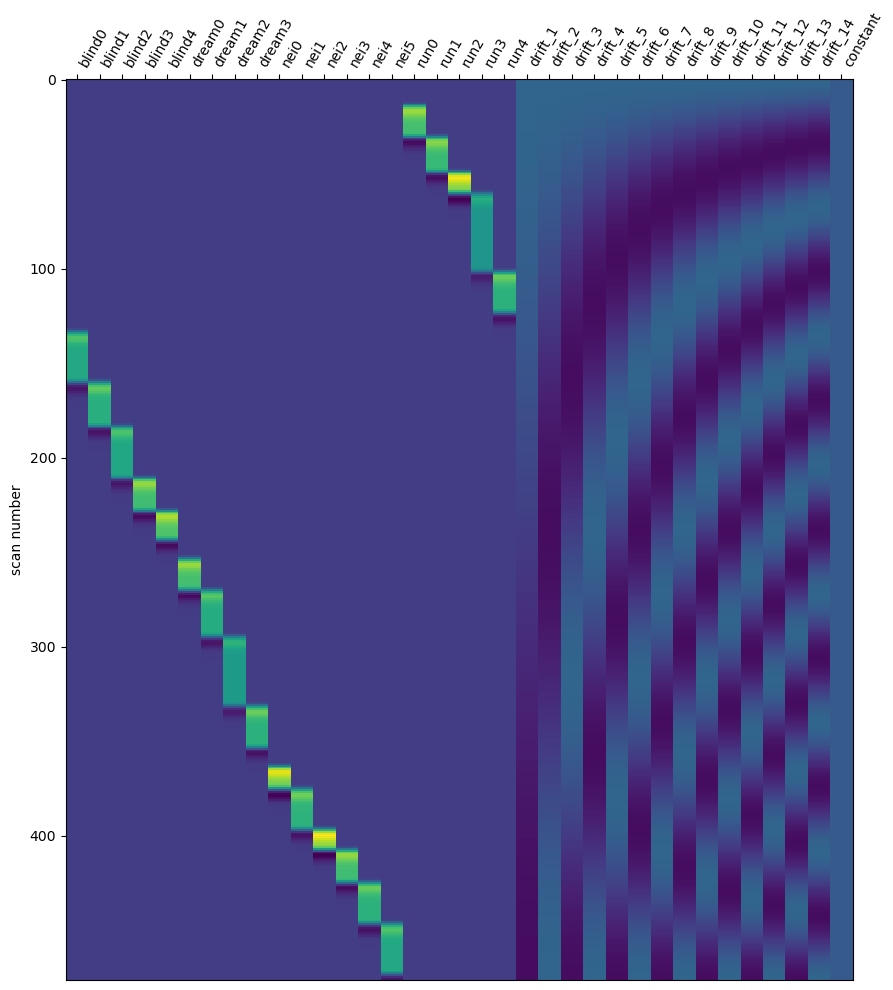

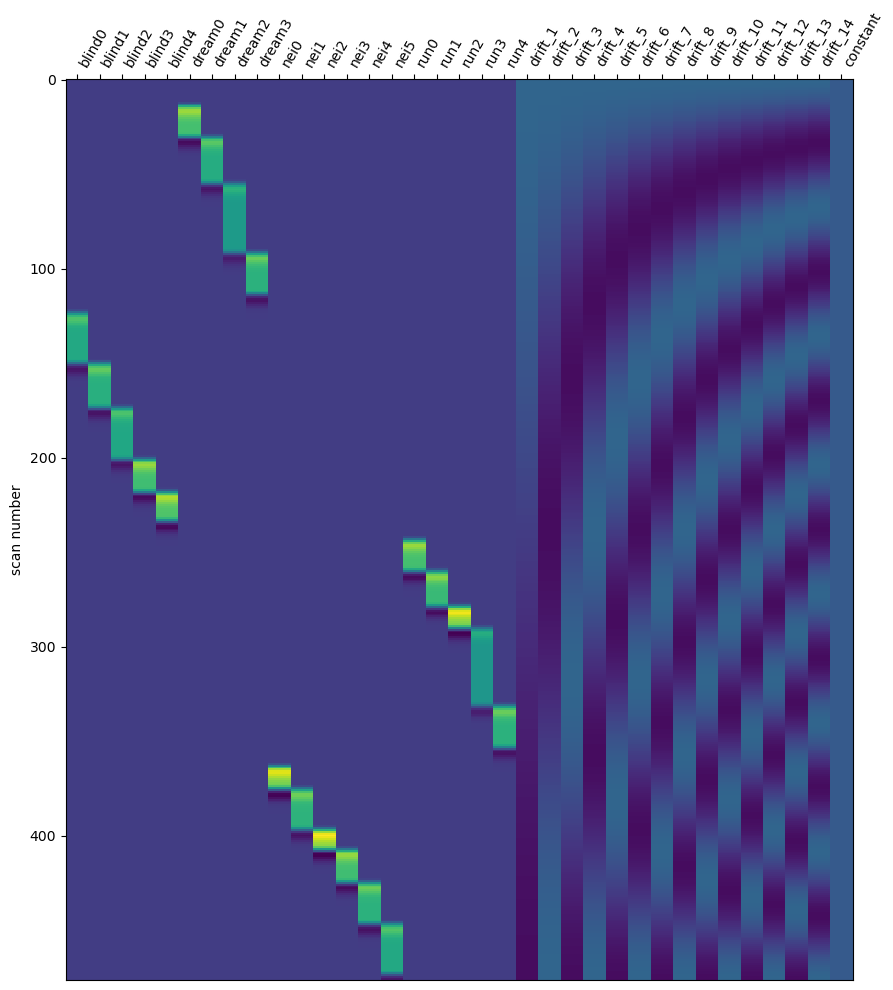

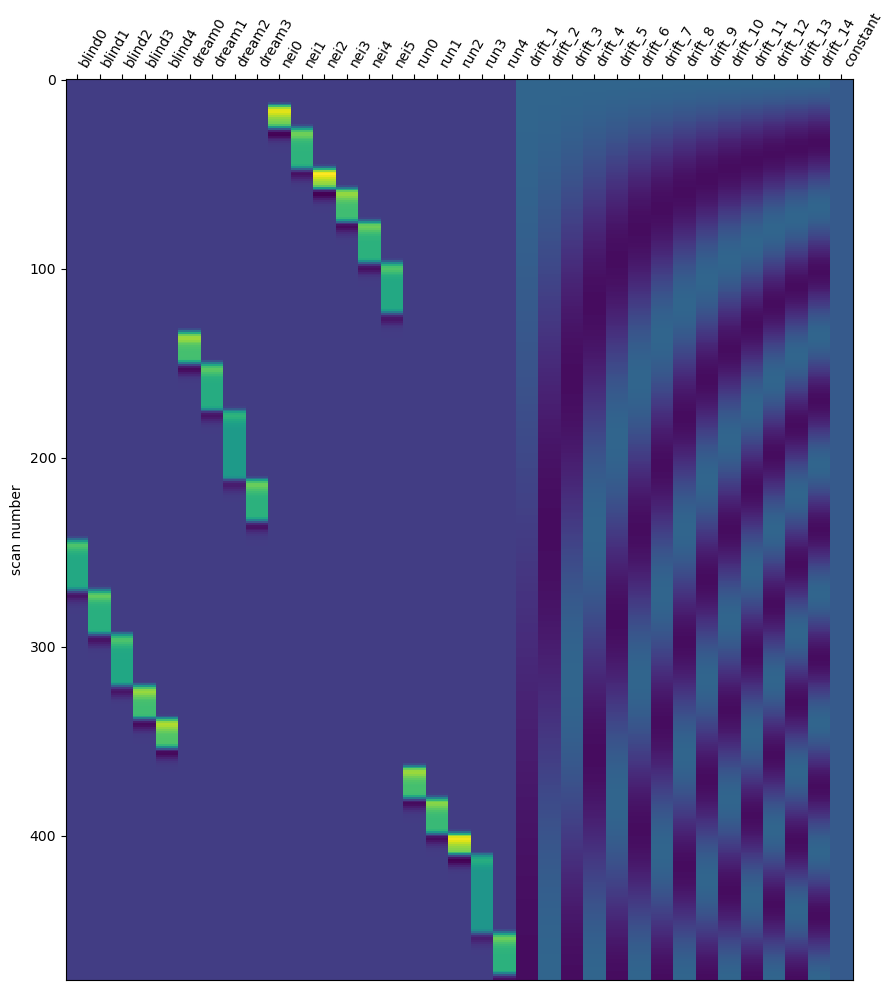

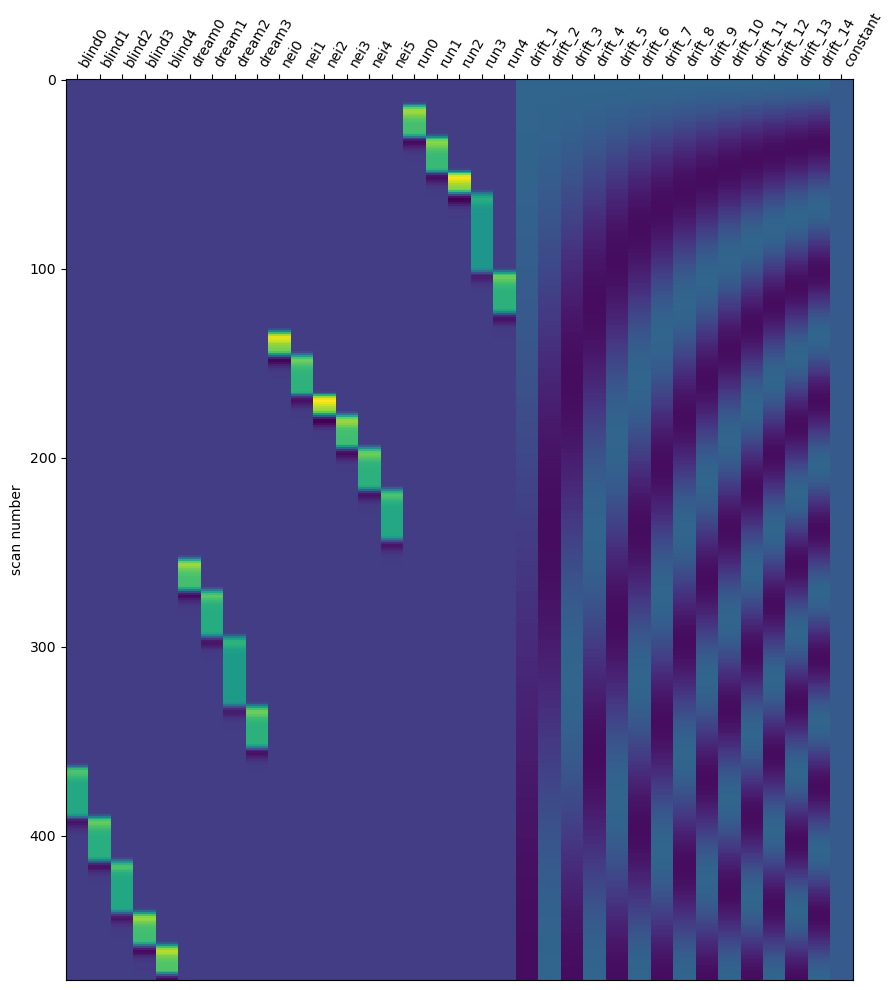

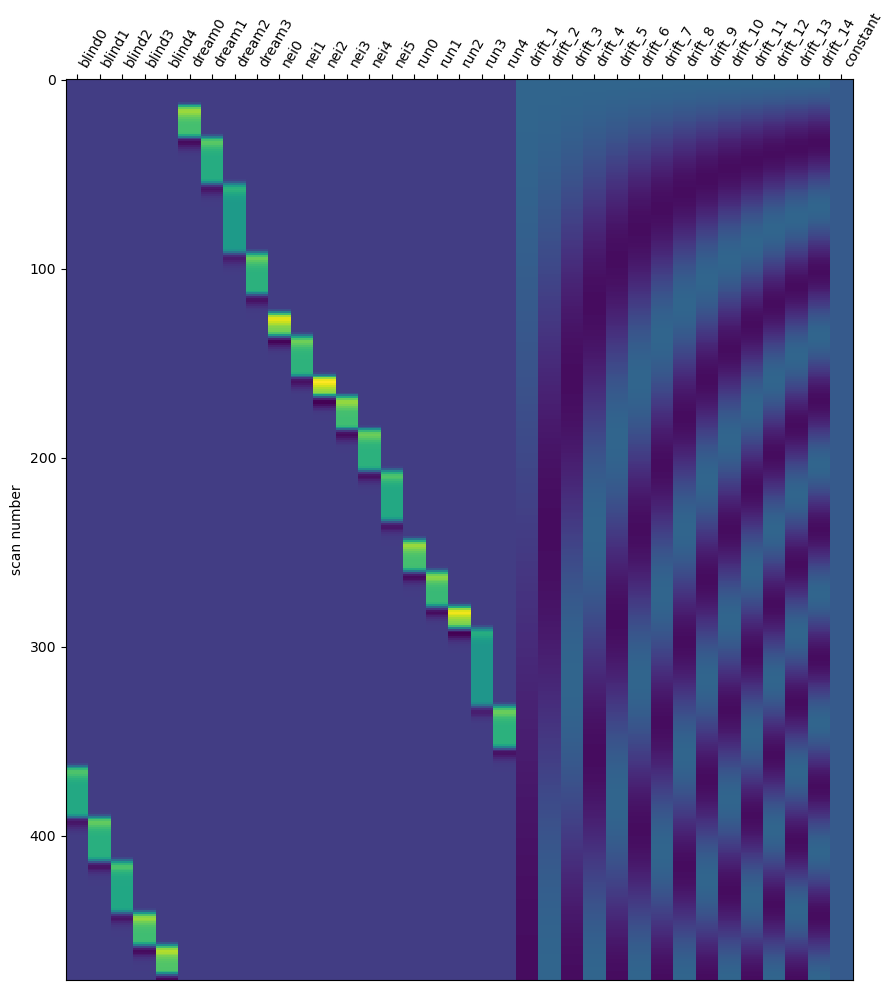

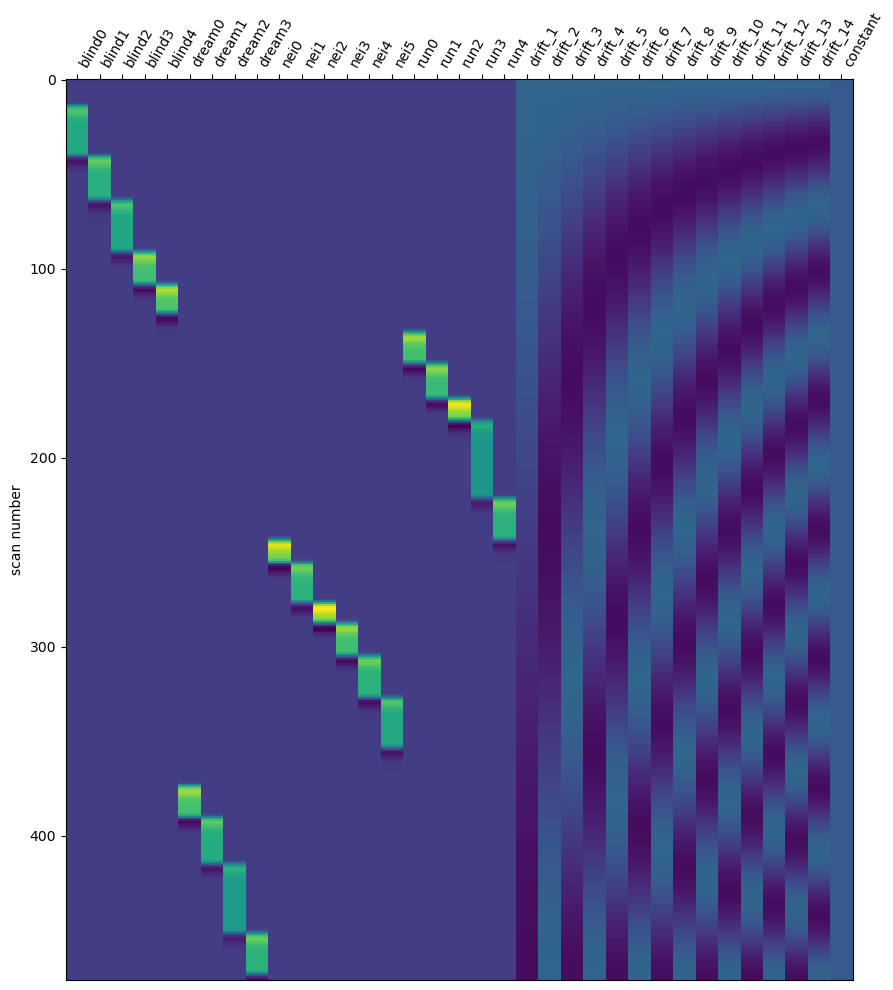

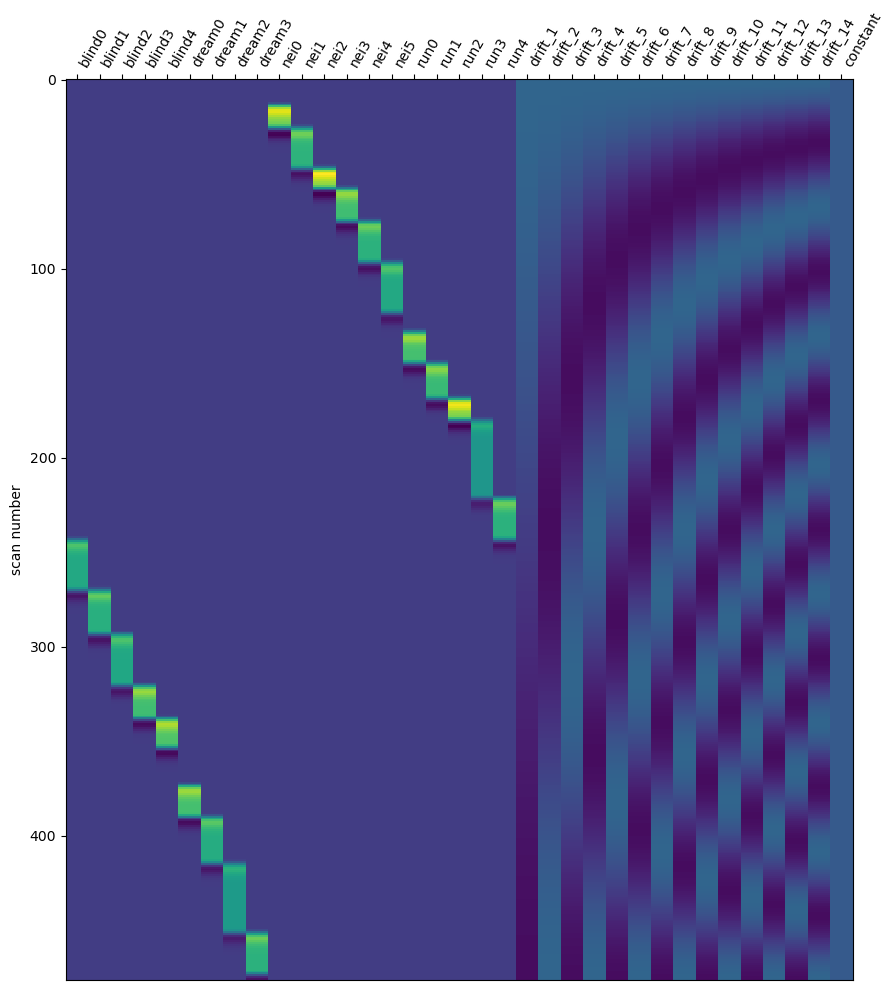

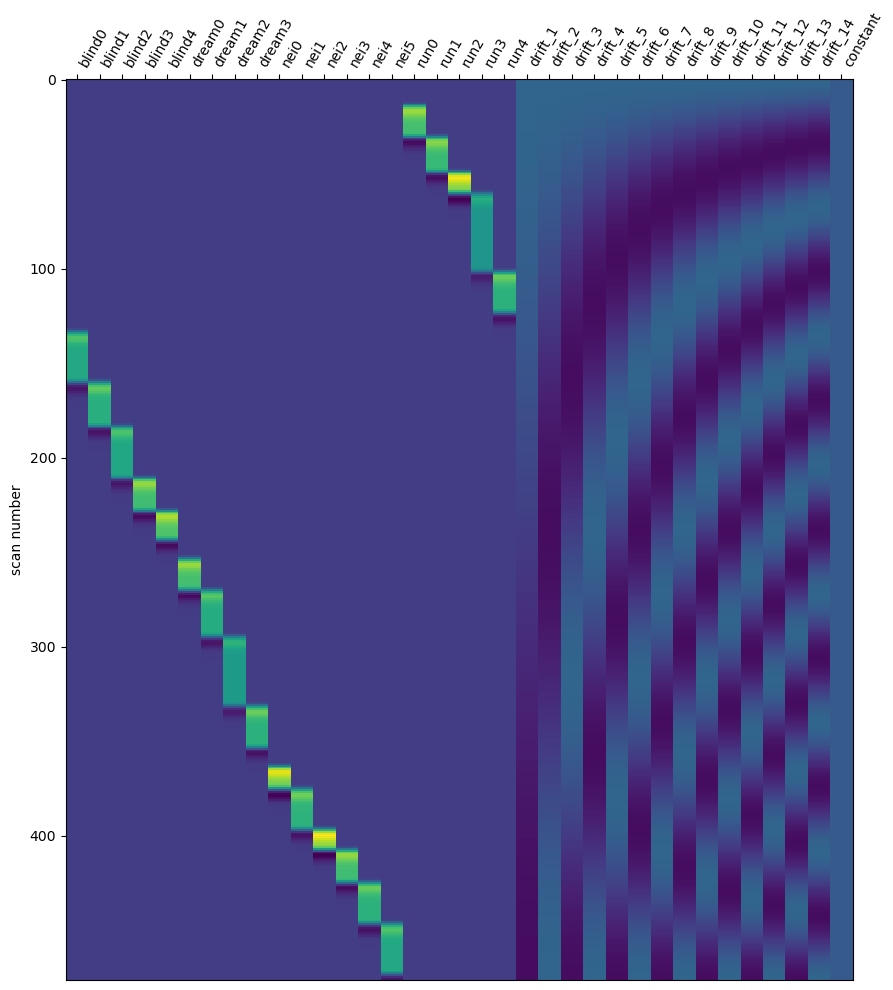

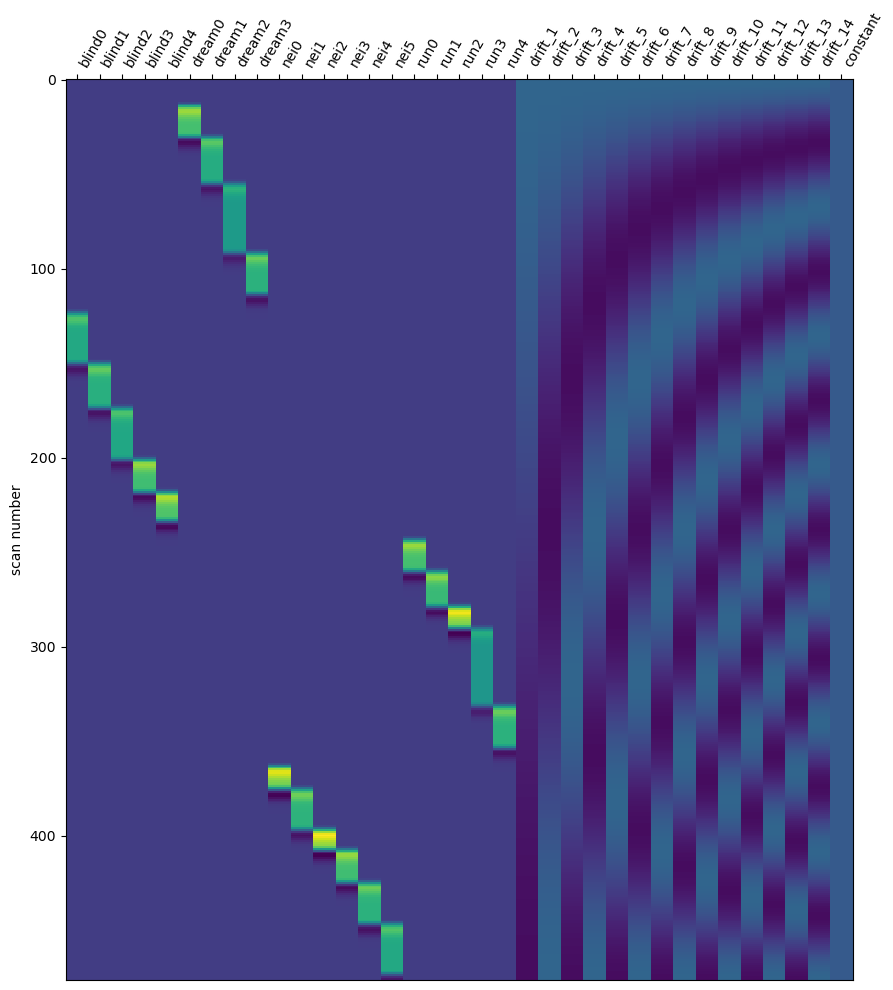

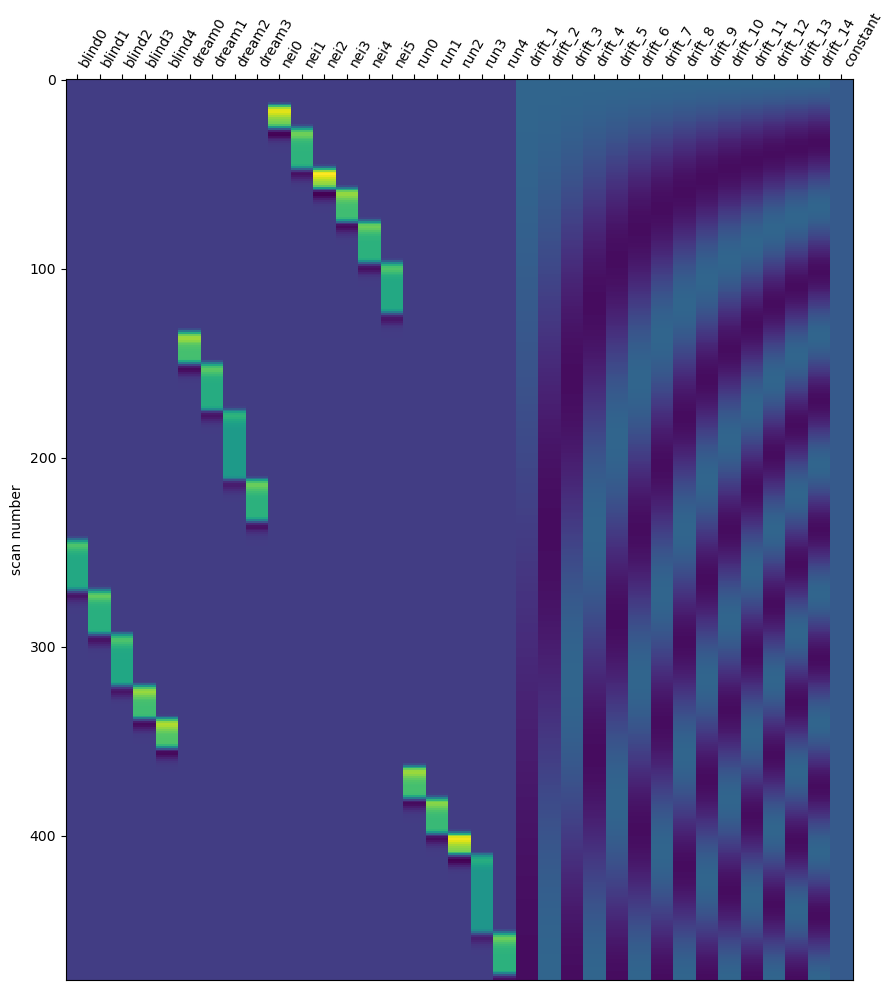

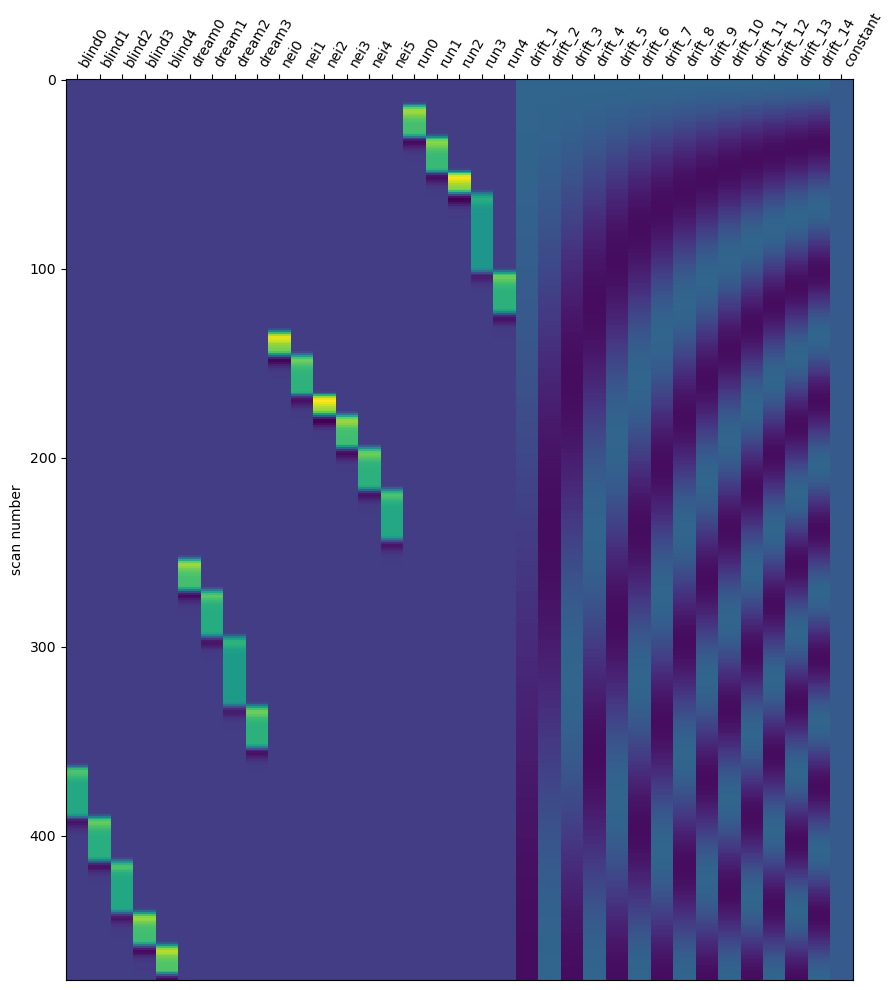

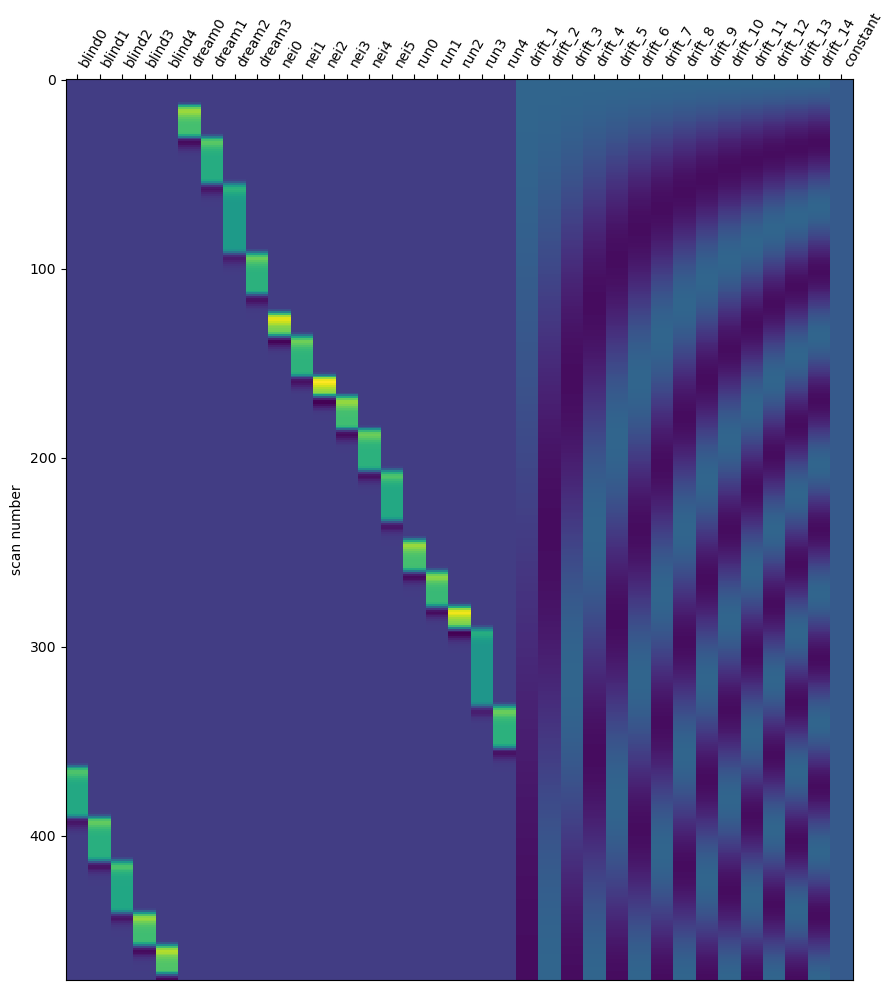

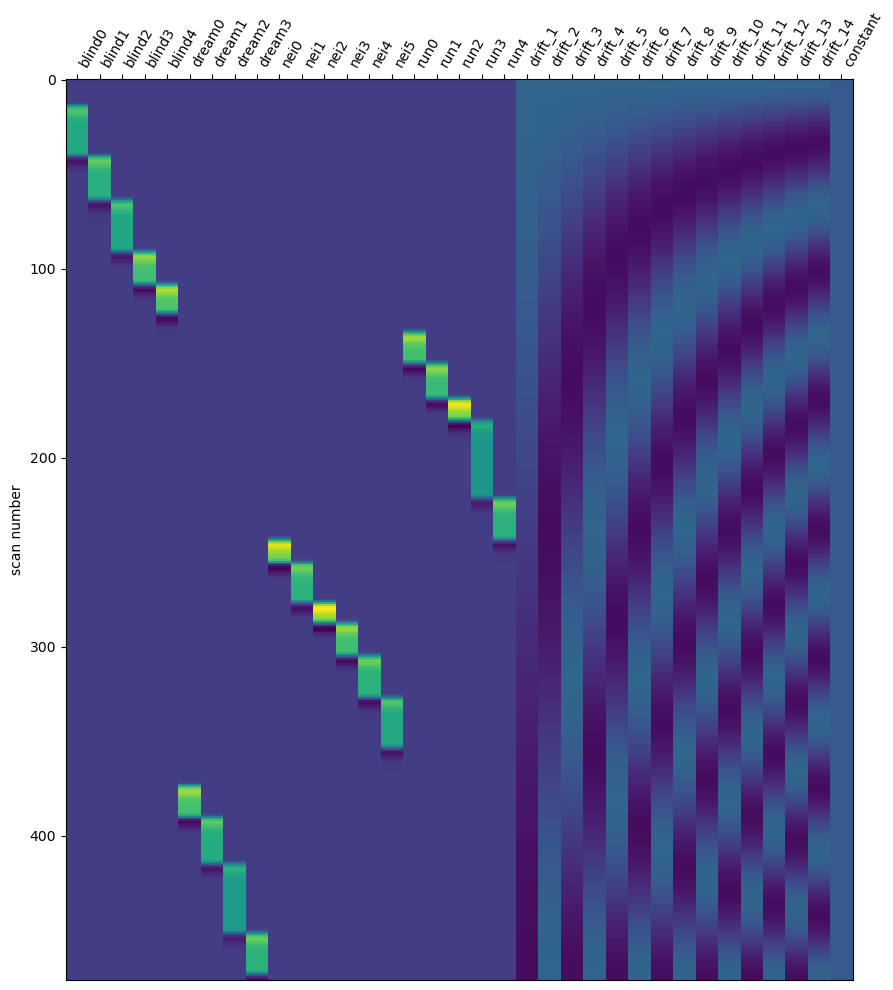

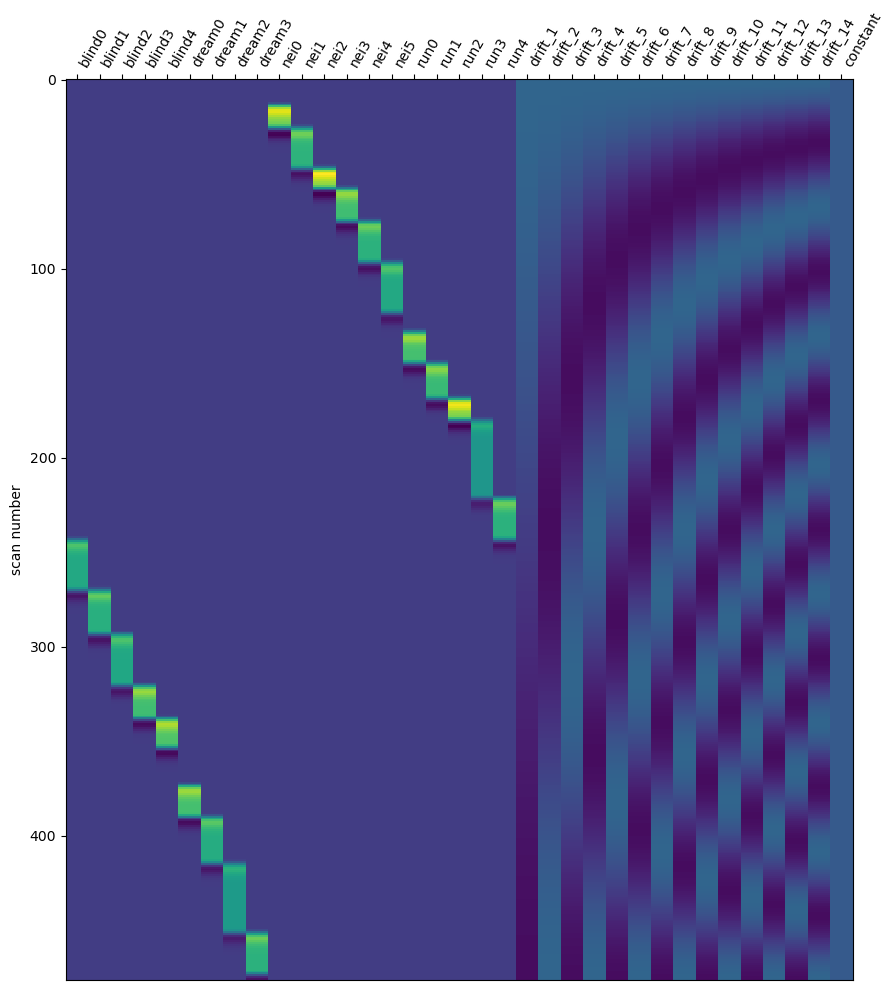

In [184]:
eb_onset = {'run':[15,40,68,85,147], 'dream':[15,40,77,132], 'nei':[15,33,65, 81, 107, 140], 'blind':[15, 55, 90, 131, 157]}
eb_offset = {'run':[40,68,85,147, 180], 'dream':[40,77,132,165], 'nei':[33,65, 81, 107, 140, 180], 'blind':[55, 90, 131, 157, 180]}

# Data Load & Trimming 
onset = {'Dream1': [0, 165, 345, 525], 'Dream2': [0, 180, 345, 525], 'Dream3': [0, 180, 360, 525], 'Dream4': [0, 180, 345, 540]}
storyName = {'RunningMan': 'run', 'BlindDate': 'blind', 'Dream':'dream', 'Neighbors':'nei'}

# sequence = np.where(all_story[sub]=='Dream')[0][0]
# cond = 'Dream'+str(int(sequence)+1)

isi = 15  # Inter-stimulus interval between events in seconds
tr = 1.5  # Repetition time in seconds
dummy = 9 

#load BOLD Volume
for sub in subjects: 
    print(sub)
    
    # Generate the events data frame
    sequence = np.where(all_story[sub]=='Dream')[0][0]
    cond = 'Dream'+str(int(sequence)+1)
    events_list = []
    for story in np.arange(0,4):    
        thisStory = storyName[all_story[sub][story]] 
        duration = [ai - bi for ai, bi in zip(eb_offset[thisStory], eb_onset[thisStory])]

        for event in range(len(eb_onset[thisStory])):
            events_list.append({
                'onset': onset[cond][story] + eb_onset[thisStory][event],
                'duration': duration[event],
                'trial_type': f'{thisStory}{event}'
            })
    events = pd.DataFrame(events_list)
    
    # Calculate the total number of scans
    total_time = events['onset'].iloc[-1] +  events['duration'].iloc[-1] + dummy  # Time after last event ends
    n_scans = int(total_time / tr)+1
    frame_times = np.arange(0, n_scans * tr, tr) # Frame times: time for each scan
    
    # Build a design matrix 
    
    design_matrix = make_first_level_design_matrix(frame_times,events,drift_model='cosine')
    print('event_size' , events.shape)
    print('desingMatrix_size', design_matrix.shape)

    # Plot the design matrix
    plot_design_matrix(design_matrix)
    plot_path = os.path.join(May_dir, 'analysis', 'designMatirx', f"sub-{sub}_task-encoding_designMatrix.png")
    plt.savefig(plot_path)

    #========================================================================================================
    encoding_files = glob.glob(os.path.join(May_dir,'denoised', 'denoised_2024', f'sub-*{sub}_task-encoding_run-*_4scNsm.nii.gz'))
    
    # Load fmri imgs for Fitting     
    func_imgs = {}
    for run in np.arange(0,2):
        print(f'Load func_img files: {encoding_files[run]}')
        func_imgs[run] = image.load_img(encoding_files[run]) 
        print('Image shape:', func_imgs[run].shape)

    output_dir = os.path.join(May_dir,'analysis', 'betas') 
    for i in range(0,2):
        glm = FirstLevelModel(t_r=1.5, hrf_model='glover', drift_model='cosine')
        glm = glm.fit(func_imgs[i], design_matrices=design_matrix)
        
        beta_map = [glm.compute_contrast(event) for event in events_type]

        # Compute and visualize beta maps
        #for j, label in enumerate(np.unique(events['trial_type'])):
            # Assuming `betas` is a list of 4D beta maps, one for each event
            #beta_map = glm.compute_contrast(label)
            #all_beta_imgs.append(beta_map)
            
            #plotting.plot_stat_map(beta_map, title=label, display_mode='z', threshold=2.3, cut_coords=5)
        combined_4d_beta_img = nib.concat_images(beta_map)
        beta_img_path = os.path.join(output_dir, f"sub-{sub}_task-encoding_run-0{i+1}_betas_image.nii.gz")
        nib.save(combined_4d_beta_img, beta_img_path)

# RDM 

In [207]:
#load BOLD Volume
from scipy.stats import pearsonr


events = ['blind0', 'blind1', 'blind2', 'blind3', 'blind4', 'dream0','dream1', 'dream2', 'dream3', 'nei0', 'nei1', 'nei2', 'nei3','nei4', 'nei5', 'run0', 'run1', 'run2', 'run3', 'run4']

sub_beta_imgs, sub_correlation= {}, {}  
for sub in subjects: 
    print(sub) 
    beta_files = glob.glob(os.path.join(output_dir, f"sub-{sub}_task-encoding_run-*_betas_image.nii.gz"))  
    beta_imgs, correlations = {},{} 
    for run in np.arange(0,2):
        beta_imgs[run] = image.load_img(beta_files[run]) 
        print('Image shape:', beta_imgs[run].shape)
        
        correlation = np.zeros((20, 20))
        for i in range(20):
            for j in range(20):
                data_i = beta_imgs[run].get_fdata()[:,:,:,i].ravel()
                data_j = beta_imgs[run].get_fdata()[:,:,:,j].ravel()
                correlation[i, j], _ = pearsonr(data_i, data_j)
            correlations[run] = correlation
    sub_beta_files[sub] = beta_imgs
    sub_correlation[sub] = correlations
    


2
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
3
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
4
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
5
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
6
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
7
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
8
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
10
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
11
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
12
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
13
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
14
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
15
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
16
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
17
Image shape: (91, 109, 91, 20)
Image shape: (91, 109, 91, 20)
18
Image shape: (91, 109, 91, 20

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Average between participants 

visual, audio, contrast = {}, {}, {}   
for sub in subjects: 
    visual[sub] = sub_correlation[sub][0]
    audio[sub] =  sub_correlation[sub][1]
    contrast[sub] = sub_correlation[sub][0] - sub_correlation[sub][1] 

visual = np.array([visual[sub] for sub in visual])
audio = np.array([audio[sub] for sub in audio])
contrast = np.array([contrast[sub] for sub in contrast])

visual_mean = np.mean(visual, axis=0)
audio_mean = np.mean(audio, axis=0)
contrast_mean = np.mean(contrast, axis=0)

In [251]:
correlation_distance= {}
for sub in subjects: 
    print(sub) 
    beta_files = glob.glob(os.path.join(output_dir, f"sub-{sub}_task-encoding_run-*_betas_image.nii.gz"))  
    for run in np.arange(0,2):
        beta_imgs[run] = image.load_img(beta_files[run])         
    correlation = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            data_i = beta_imgs[0].get_fdata()[:,:,:,i].ravel()
            data_j = beta_imgs[1].get_fdata()[:,:,:,j].ravel()
            correlation[i, j], _ = pearsonr(data_i, data_j)
    correlation_distance[sub] = correlation
    

correlation_distance = np.array([correlation_distance[sub] for sub in correlation_distance])
correlation_distance = np.mean(correlation_distance, axis=0)

2
3
4
5
6
7
8
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
27
28
29
30
31
32
33


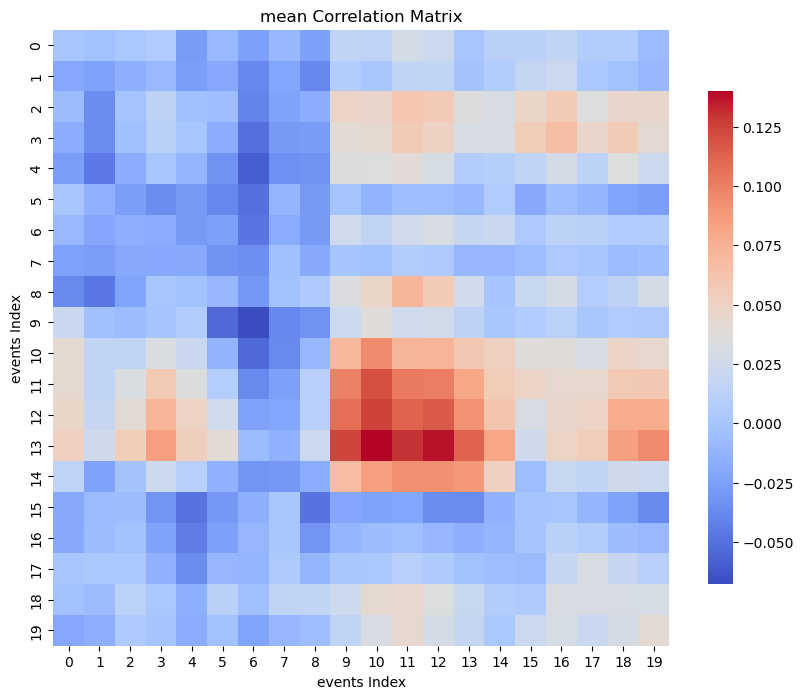

In [254]:
# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Adjust the size of the figure as needed
sns.heatmap(correlation_distance, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add titles and labels as necessary
plt.title('mean Correlation Matrix')
plt.xlabel('events Index')
plt.ylabel('events Index')

# Show the plot
plt.show()

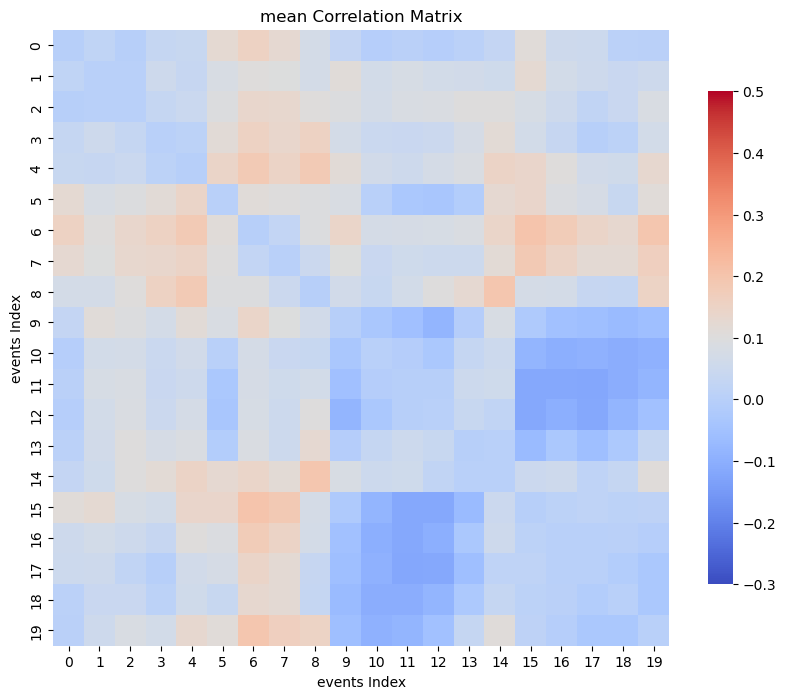

In [248]:
# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Adjust the size of the figure as needed
sns.heatmap(contrast_mean, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmax=0.5, vmin=-0.3)

# Add titles and labels as necessary
plt.title('mean Correlation Matrix')
plt.xlabel('events Index')
plt.ylabel('events Index')

# Show the plot
plt.show()

In [331]:
# Compare correlations between smallupdate and bigupdate 
story_boundary = {'RunningMan': range(5), 'Dream' : range(5,9), 'Blind' : range(9,14), 'Neighbors' : range(14,20)}
small_update = {'RunningMan': range(5), 'Dream' : [0,3], 'Blind' : [3,4], 'Neighbors' : [4,5]}
bid_update = {'Dream' : [1,2], 'Blind' : [0,1,2], 'Neighbors' : [0,1,2,3]}

visual, audio, contrast = {}, {}, {}   
for sub in subjects: 
    visual[sub] = sub_correlation[sub][0]
    audio[sub] =  sub_correlation[sub][1]
    contrast[sub] = sub_correlation[sub][0] - sub_correlation[sub][1] 

visual = np.array([visual[sub] for sub in visual])
audio = np.array([audio[sub] for sub in audio])
contrast = np.array([contrast[sub] for sub in contrast])

### Contrast of visual and audio correlation

In [392]:
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
mask_x = expand_mask(mask)
output_dir = os.path.join(May_dir,'analysis', 'betas') 

roi_masked_correlation, roi_masked_contrast = {},{}
for roi in tqdm([5,19,28,32]):    
    # Brain_Data objects can be converted to nibabel NIfTI images using to_nifti method
    mask_img = mask_x[roi].to_nifti()
    mask_data = mask_img.get_fdata()   
    
    # Expanding mask dimensions to match beta_data
    expanded_mask_data = mask_data[:, :, :, np.newaxis]
    expanded_mask_data = np.repeat(expanded_mask_data, 20, axis=3)

    sub_masked_correlation, sub_masked_contrast= {}, {}
    for sub in subjects: 
        #print(sub, 'load betas')
        beta_files = glob.glob(os.path.join(output_dir, f"sub-{sub}_task-encoding_run-*_betas_image.nii.gz"))  

        masked_beta_img ={}
        for run in np.arange(0,2):
            beta_imgs = image.load_img(beta_files[run])    
            beta_data = beta_imgs.get_fdata()
            masked_beta_data = beta_data * expanded_mask_data
            masked_beta_img[run] = image.new_img_like(beta_imgs, masked_beta_data)
            
            correlation = np.zeros((20, 20))
            for i in range(20):
                for j in range(20):
                    data_i = masked_beta_img[run].get_fdata()[:,:,:,i].ravel()
                    data_j = masked_beta_img[run].get_fdata()[:,:,:,j].ravel()
                    correlation[i, j], _ = pearsonr(data_i, data_j)
            masked_beta_img[run] = correlation
        sub_masked_correlation[sub] = masked_beta_img
        sub_masked_contrast[sub] = masked_beta_img[1] - masked_beta_img[0] 
    roi_masked_correlation[roi] = sub_masked_correlation
    roi_masked_contrast[roi] = sub_masked_contrast

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [31:56<00:00, 479.08s/it]


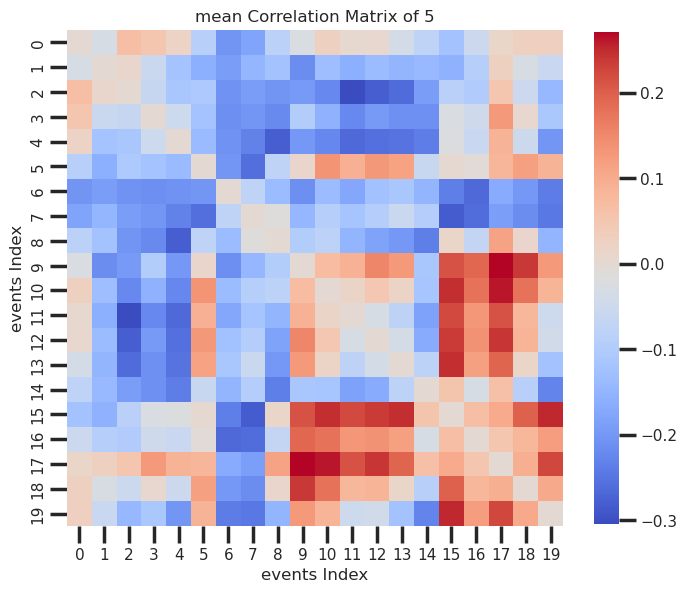

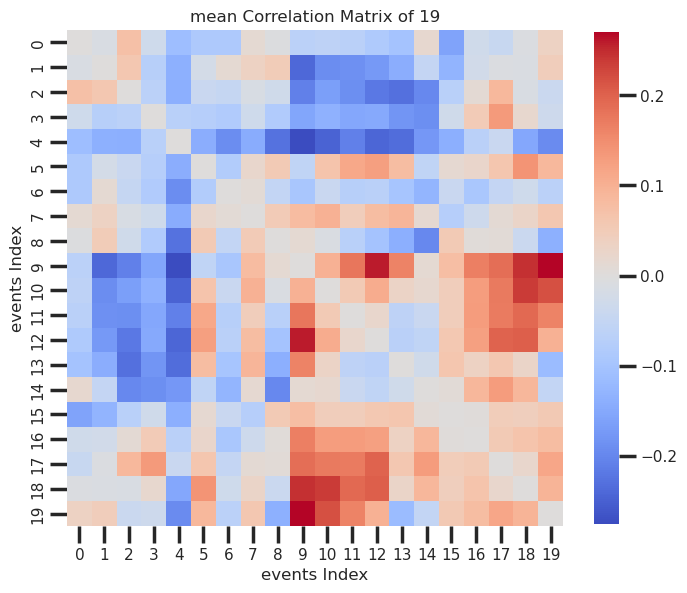

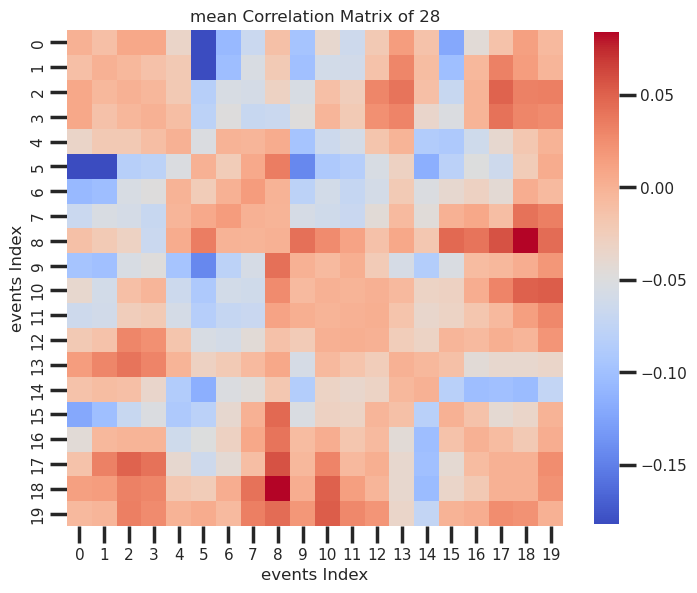

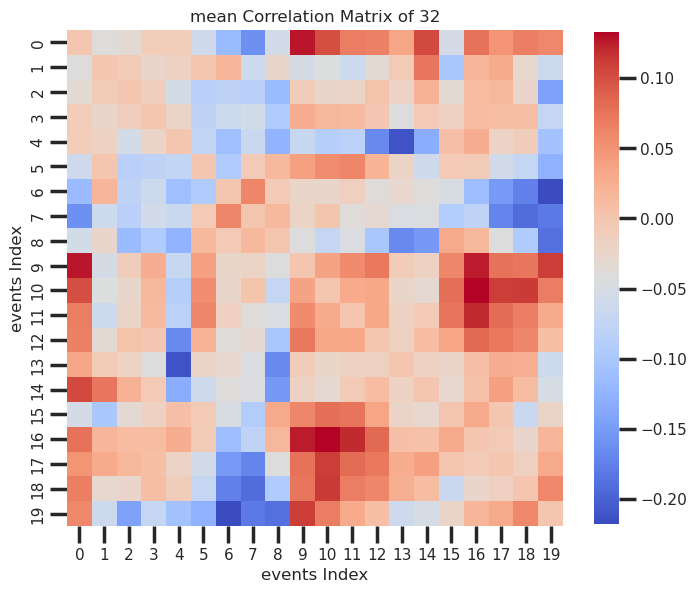

In [531]:
roi_masked_visual_corr, roi_masked_audio_corr, contrast = {}, {}, {}
for roi in [5,19,28,32]:
    contrast[roi] = np.array([roi_masked_contrast[roi][sub] for sub in roi_masked_contrast[roi]]).mean(axis = 0) 

    # Create a heatmap using seaborn
    plt.figure(figsize=(8, 8))  # Adjust the size of the figure as needed
    sns.heatmap(contrast[roi], annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

    # Add titles and labels as necessary
    plt.title(f'mean Correlation Matrix of {roi}')
    plt.xlabel('events Index')
    plt.ylabel('events Index')

    # Show the plot
    plt.show()


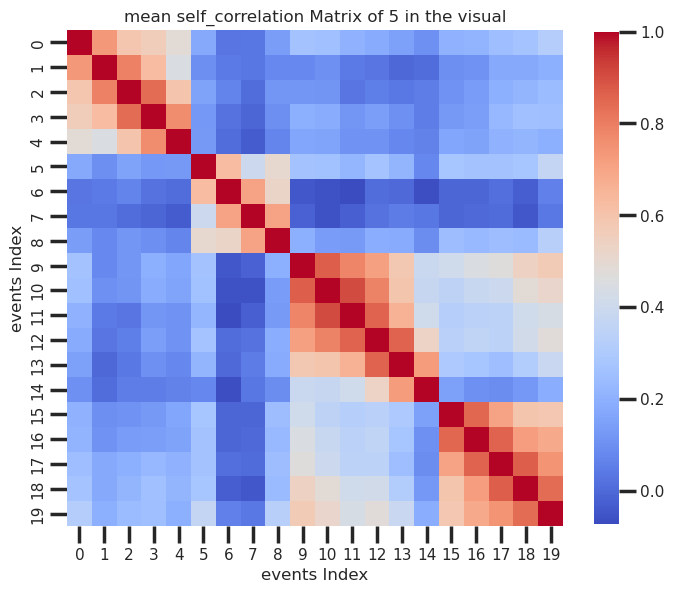

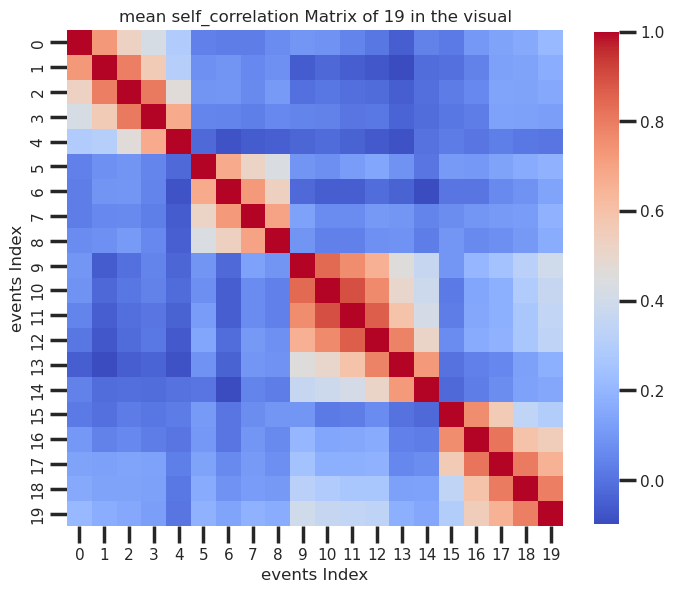

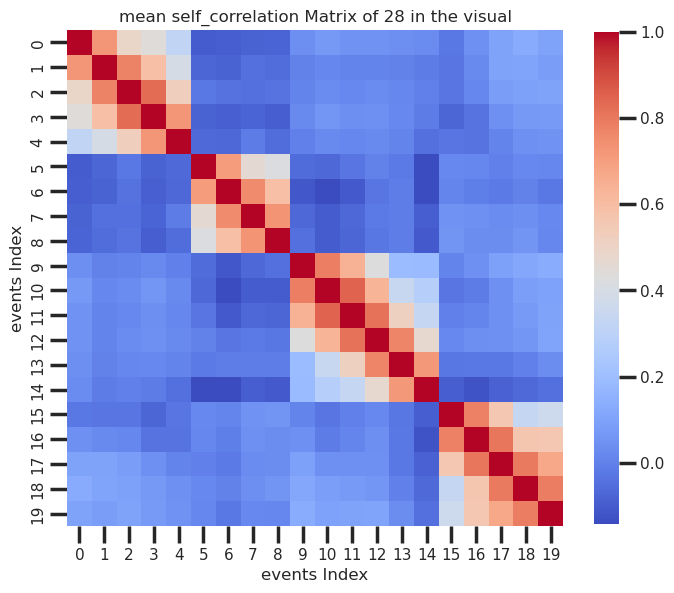

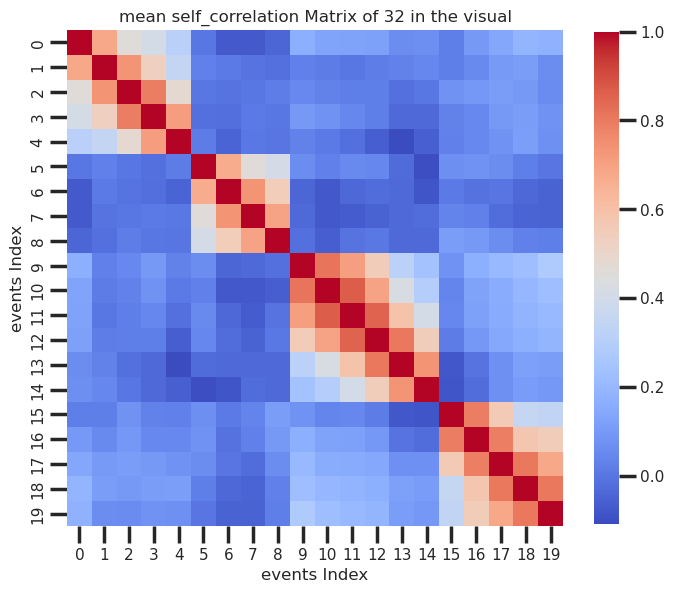

In [672]:
roi_masked_visual_corr, roi_masked_audio_corr, contrast = {}, {}, {}
for roi in [5,19,28,32]:
    contrast[roi] = np.array([roi_masked_correlation[roi][sub][1] for sub in roi_masked_contrast[roi]]).mean(axis = 0) 

    # Create a heatmap using seaborn
    plt.figure(figsize=(8, 8))  # Adjust the size of the figure as needed
    sns.heatmap(contrast[roi], annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

    # Add titles and labels as necessary
    plt.title(f'mean self_correlation Matrix of {roi} in the visual')
    plt.xlabel('events Index')
    plt.ylabel('events Index')

    # Show the plot
    output_dir = '/mnt/c/Users/since/Dropbox/jany/Movie_recall/_DATA'
    plot_path = os.path.join(output_dir, f"{roi}_mean_self_correlation_AUDIO.png")
    plt.savefig(plot_path)
    plt.show()


### Correlation between visaul and audio

In [602]:
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
mask_x = expand_mask(mask)
output_dir = os.path.join(May_dir,'analysis', 'betas') 

roi_masked_btw_correlation = {} 
for roi in tqdm([5,19,28,32]):    
    # Brain_Data objects can be converted to nibabel NIfTI images using to_nifti method
    mask_img = mask_x[roi].to_nifti()
    mask_data = mask_img.get_fdata()   
    
    # Expanding mask dimensions to match beta_data
    expanded_mask_data = mask_data[:, :, :, np.newaxis]
    expanded_mask_data = np.repeat(expanded_mask_data, 20, axis=3)

    sub_masked_btw_correlation ={} 
    for sub in subjects: 
        #print(sub, 'load betas')
        beta_files = glob.glob(os.path.join(output_dir, f"sub-{sub}_task-encoding_run-*_betas_image.nii.gz"))  
        for run in np.arange(0,2):
            beta_imgs = image.load_img(beta_files[run])    
            beta_data = beta_imgs.get_fdata()
            masked_beta_data = beta_data * expanded_mask_data
            masked_beta_img[run] = image.new_img_like(beta_imgs, masked_beta_data)
            
        correlation = np.zeros((20, 20))
        for i in range(20):
            for j in range(20):
                data_i = masked_beta_img[0].get_fdata()[:,:,:,i].ravel()
                data_j = masked_beta_img[1].get_fdata()[:,:,:,j].ravel()
                correlation[i, j], _ = pearsonr(data_i, data_j)
        sub_masked_btw_correlation[sub] = correlation
    roi_masked_btw_correlation[roi] = sub_masked_btw_correlation

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [17:21<00:00, 260.27s/it]


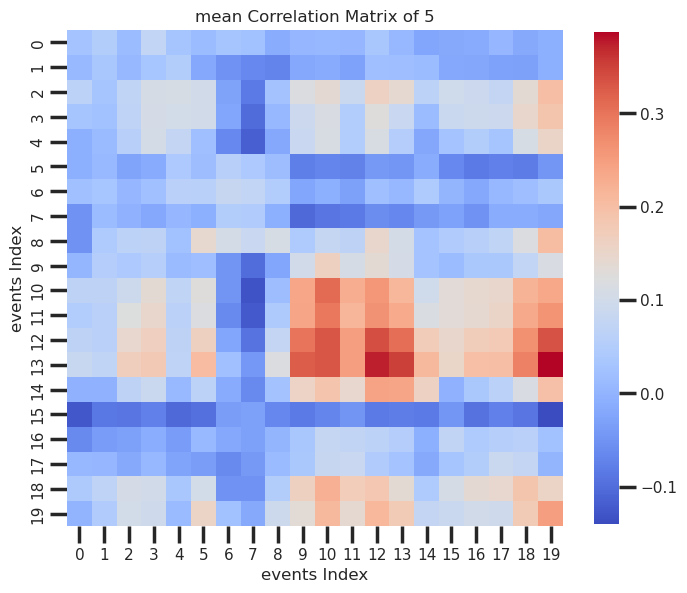

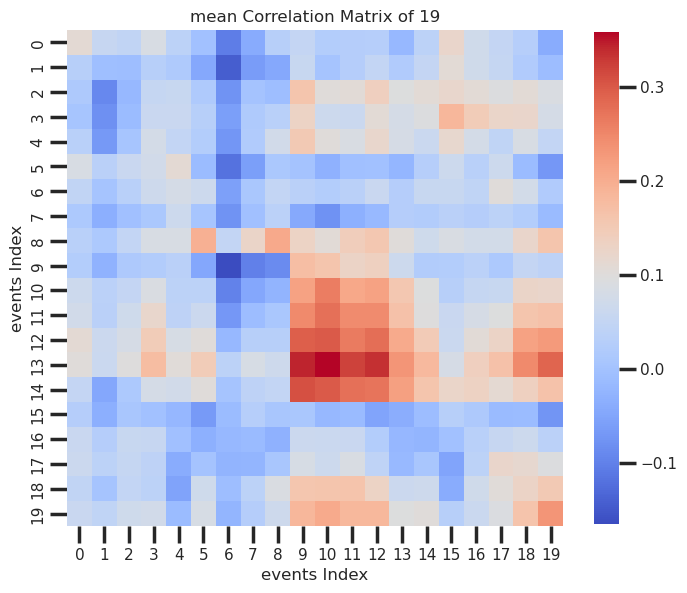

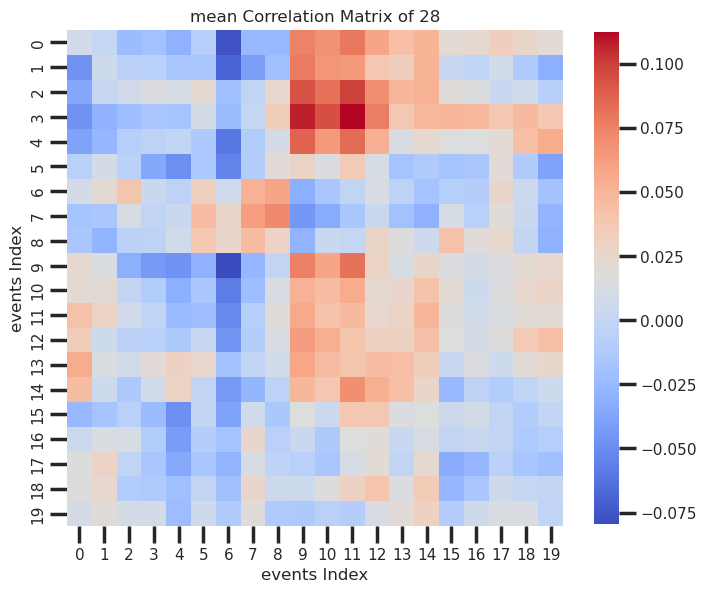

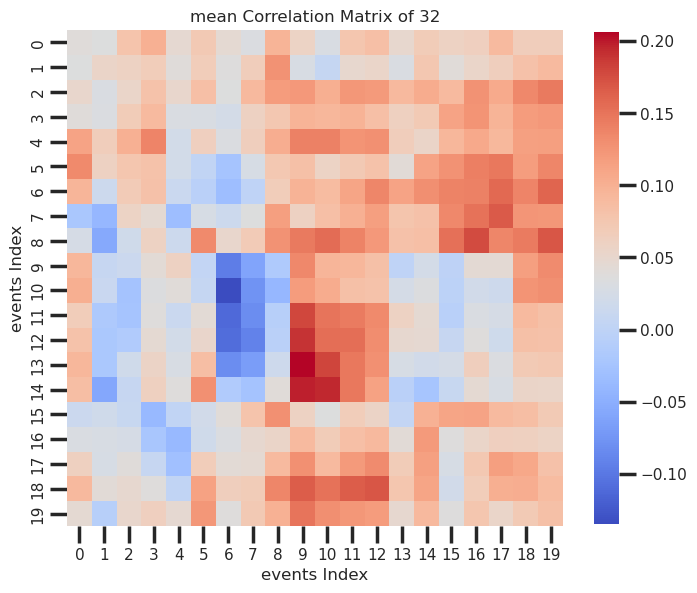

In [605]:
interCorrelation = {}
for roi in [5,19,28,32]:
    interCorrelation[roi] = np.array([roi_masked_btw_correlation[roi][sub] for sub in roi_masked_contrast[roi]]).mean(axis = 0) 

    # Create a heatmap using seaborn
    plt.figure(figsize=(8, 8))  # Adjust the size of the figure as needed
    sns.heatmap(interCorrelation[roi], annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

    # Add titles and labels as necessary
    plt.title(f'mean Correlation Matrix of {roi}')
    plt.xlabel('events Index')
    plt.ylabel('events Index')

    # Show the plot
    plt.show()


### Hypothesis for inter-encoding session 

In [679]:
# Define hypothesis matrices
stories = ['RunningMan', 'Dream', 'Blind','Neighbors'] 
story_boundary = {'Blind': range(5), 'Dream' : range(5,9), 'Neighbors' : range(9,15), 'RunningMan' : range(15,20)}

story_start = {'Blind': 0, 'Dream' : 5, 'Neighbors' : 9, 'RunningMan' : 15}
story_end = {'Blind': 5, 'Dream' : 9, 'Neighbors' : 15, 'RunningMan' : 20}

event_score  = {'RunningMan': [1,1,1,1,1], 'Dream' : [1,0,0,1], 'Blind' : [0,0,1,1,0], 'Neighbors' : [0,0,0,0,1,1]}
#detail_score = {'RunningMan': [1,0.5,1,0.5,0.5], 'Dream' : [0.5,0.5,0.5,0.5], 'Blind' : [1,1,1,0.5,0.5], 'Neighbors' : [0.5,1,1,1,1,0.5]} 

diagonal_mat = np.zeros((20, 20))
for i in range(20):
    diagonal_mat[i,i] = 1 

# EPISODIC MATRIXS
episodic = np.zeros((20, 20)) 
for i in range(20):
    episodic[i,i] = 1

# STORY MATRIXS
story = np.zeros((20, 20))
for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    story[start:end, start:end] = 0.5

# EVENT MATRIXS
event = np.zeros((20, 20)) 
for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    event[start:end, start:end] = 0
    for idx,loc in enumerate(story_boundary[whcihStory]):
        event[loc,loc] = event_score[whcihStory][idx]


# hiearchy MATRIXS
hiearchy = np.zeros((20, 20))
for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    hiearchy[start:end, start:end] = 0.5

    for idx,loc in enumerate(story_boundary[whcihStory]):
        hiearchy[loc,loc] = event_score[whcihStory][idx]

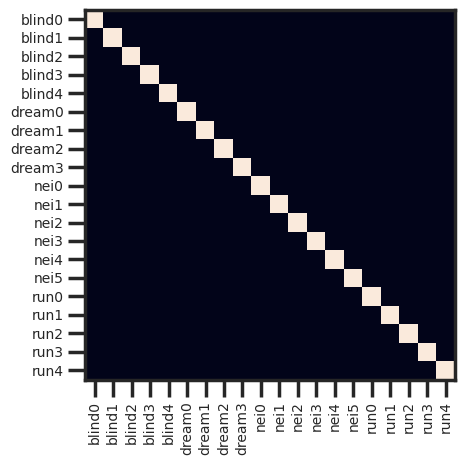

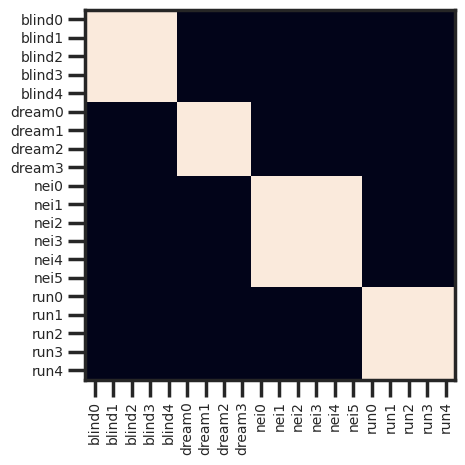

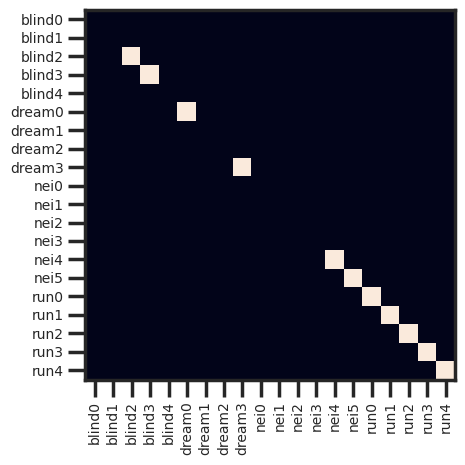

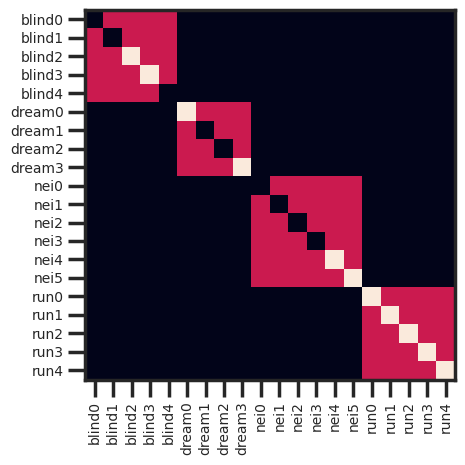

In [680]:
x_lab =['blind0', 'blind1', 'blind2', 'blind3', 'blind4', 'dream0','dream1', 'dream2', 'dream3', 'nei0', 'nei1', 'nei2', 'nei3','nei4', 'nei5', 'run0', 'run1', 'run2', 'run3', 'run4']
y_lab =['blind0', 'blind1', 'blind2', 'blind3', 'blind4', 'dream0','dream1', 'dream2', 'dream3', 'nei0', 'nei1', 'nei2', 'nei3','nei4', 'nei5', 'run0', 'run1', 'run2', 'run3', 'run4']
# plot model matrices (uncomment if desired) #

size = 10 
angle = 90 

plt.imshow(episodic)
plt.xticks(range(len(x_lab)), x_lab, fontsize=size, rotation=angle)
plt.yticks(range(len(y_lab)), y_lab, fontsize=size)
plt.show()

plt.imshow(story)
plt.xticks(range(len(x_lab)), x_lab, fontsize=size, rotation=angle)
plt.yticks(range(len(y_lab)), y_lab, fontsize=size)
plt.show()

plt.imshow(event)
plt.xticks(range(len(x_lab)), x_lab, fontsize=size, rotation=angle)
plt.yticks(range(len(y_lab)), y_lab, fontsize=size)
plt.show()

plt.imshow(hiearchy)
plt.xticks(range(len(x_lab)), x_lab, fontsize=size, rotation=angle)
plt.yticks(range(len(y_lab)), y_lab, fontsize=size)
plt.show()

In [686]:
from scipy.stats import pointbiserialr

upper_triangle_indices = np.triu_indices(20, k=1)

# flatten beta and hypothesis mat in to vectors 
hypotheses = {'episodic':episodic, 'story': story, 'event': event, 'hiearchy': hiearchy}
conditions= ['episodic','story', 'event', 'hiearchy']
#conditions= ['story', 'event']


flatten_hyp = {}
for cond in conditions:
    matrix = hypotheses[cond][upper_triangle_indices]
    flatten_hyp[cond] = matrix.flatten()
    
    
flatten_betas = {} 
#for mask in range(len(mask_files)):
for mask in [5,19,28,32]:
    sub_flatten_betas = {} 
    for sub in subjects: 
        #matrix = roi_masked_btw_correlation[mask][sub]#[upper_triangle_indices]
        matrix = roi_masked_correlation[mask][sub][1][upper_triangle_indices]
        sub_flatten_betas[sub] = matrix.flatten()
    flatten_betas[mask]  = sub_flatten_betas
    

# Compute the Pearson correlation between the two vectors
# Isolate the z-scored correlation coefficients and make lists
roi_mat_corrs, roi_mat_p_vals = {},{} 
#for mask in range(len(mask_files)):
for mask in [5,19,28,32]:
    cond_mat_corrs, cond_mat_p_vals  = {},{} 
    for cond in conditions:
        mat_corrs, mat_p_val = [] , [] 
        for sub in subjects: 
            corr, p_val = pointbiserialr(flatten_betas[mask][sub],flatten_hyp[cond])
            mat_corrs.append(corr)
            mat_p_val.append(p_val)
        cond_mat_corrs[cond] = mat_corrs
        cond_mat_p_vals[cond] = mat_p_val
    roi_mat_corrs[mask] = cond_mat_corrs
    roi_mat_p_vals[mask] = cond_mat_p_vals


In [687]:
# Create a dataframe of the lists
import statsmodels.stats.multicomp as mc
from statsmodels.stats.anova import AnovaRM



roi_corr_df = {} 
AOVs = {} 
comps = {} 
#for mask in range(len(mask_files)):
for mask in [5,19,28,32]:
    corr_df = pd.DataFrame(list(zip(roi_mat_corrs[mask]['episodic'],
                                    roi_mat_corrs[mask]['story'],
                                    roi_mat_corrs[mask]['event'],
                                    roi_mat_corrs[mask]['hiearchy'] )), 
                           columns=(['story', 'event','hiearchy', 'episodic',]))

    # Convert to a 'long' format dataframe for 1-way ANOVA
    corr_df_stacked = corr_df.stack().reset_index()
    corr_df_stacked.columns = ['subject','model','zscore']
    roi_corr_df[mask] = corr_df_stacked
    
    # One-way repeated-measures ANOVA
    AOV = AnovaRM(data=corr_df_stacked, depvar='zscore', subject='subject', within=['model']).fit()
    AOVs[mask] = AOV
    print(mask, AOV)
    
    # One-way repeated-measures ANOVA
    comp = mc.MultiComparison(corr_df_stacked['zscore'], corr_df_stacked['model'])
    post_hoc_res = comp.tukeyhsd()
    comps[mask] =post_hoc_res
    print(post_hoc_res.summary())


5                Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
model -2.6316 1.0000 29.0000 1.0000

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj  lower  upper  reject
----------------------------------------------------
episodic  event      0.0   1.0 -0.0413 0.0413  False
----------------------------------------------------
19                Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
model -5.6942 1.0000 29.0000 1.0000

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj  lower  upper  reject
----------------------------------------------------
episodic  event      0.0   1.0 -0.0452 0.0452  False
----------------------------------------------------
28                Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
model -8.1119 1.0000 29.0000 1.0000

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 mea

In [684]:
roi_corr_df[5]['roi'] = 5
roi_corr_df[19]['roi'] = 19
roi_corr_df[28]['roi'] = 28
roi_corr_df[32]['roi'] = 32

roi_corr_df_concat = pd.concat([roi_corr_df[5], roi_corr_df[19], roi_corr_df[28], roi_corr_df[32]])

roi_corr_df_concat

,subject,model,zscore,roi
0,0,event,0.778407,5
1,0,episodic,0.778407,5
2,1,event,0.613064,5
3,1,episodic,0.613064,5
4,2,event,0.662740,5
...,...,...,...,...
55,27,episodic,0.801934,32
56,28,event,0.632012,32
57,28,episodic,0.632012,32
58,29,event,0.617976,32


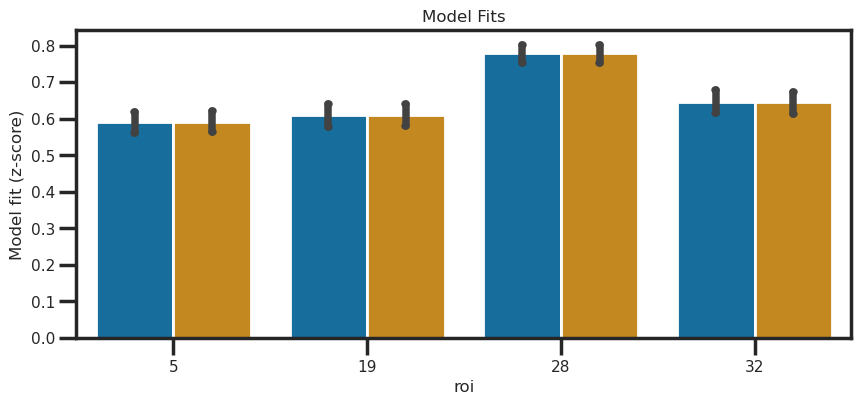

In [685]:
#BARPLOT VERSION
import seaborn as sns


# #for mask in range(len(mask_files)):
# for loc, mask in enumerate([5,19,28,32]):
#     #parts = mask_files[mask].split('_')
#     roi = ROIs[mask]
    
sns.set(style="ticks",context=("poster"),font_scale=0.5)
fig, ax = plt.subplots(figsize = (10, 4),sharey=True)   
#ax.set_ylim(0.0,0.09)
# mat = roi_corr_df[mask]
fig = sns.barplot(x="roi", y='zscore', hue= 'model', data=roi_corr_df_concat, capsize=.005, ci=95, palette="colorblind")
#fig = sns.swarmplot(x="roi", y='zscore',dodge=True, data=roi_corr_df_concat, size=1.5, color="k", alpha=.5)
#fig.axes.get_legend()
plt.title(f"Model Fits")
plt.ylabel("Model fit (z-score)")
#plt.xlabel("Model")
#plt.tight_layout()
ax.legend_.remove()
plt.savefig('Model_fits for beta constrast.pdf')


 ## Load Betas according to each ROI vectors

In [469]:
### Warning !! It takes much time .. almost 1 hours... ## with neurosynth

from scipy.stats import pearsonr
from tqdm import tqdm
from nltools.data import Brain_Data
from nltools.mask import expand_mask

mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
mask_x = expand_mask(mask)
output_dir = os.path.join(May_dir,'analysis', 'betas') 

roi_concated_correlation = {} 
for roi in tqdm([5,19,28,32]):    
    # Brain_Data objects can be converted to nibabel NIfTI images using to_nifti method
    mask_img = mask_x[roi].to_nifti()
    mask_data = mask_img.get_fdata()   
    
    # Expanding mask dimensions to match beta_data
    expanded_mask_data = mask_data[:, :, :, np.newaxis]
    expanded_mask_data = np.repeat(expanded_mask_data, 20, axis=3)

    sub_concated_correlation = {}
    for sub in subjects: 
        #print(sub, 'load betas')
        beta_files = glob.glob(os.path.join(output_dir, f"sub-{sub}_task-encoding_run-*_betas_image.nii.gz"))  

        masked_beta_img ={}
        for run in np.arange(0,2):
            beta_imgs = image.load_img(beta_files[run])    
            beta_data = beta_imgs.get_fdata()
            masked_beta_data = beta_data * expanded_mask_data
            masked_beta_img[run] = image.new_img_like(beta_imgs, masked_beta_data)

        # Concat betas 
        concatenated_img = image.concat_imgs([masked_beta_img[0], masked_beta_img[1]])
        
        #print('Start to calculate a correlation') 
        correlation = np.zeros((40, 40))
        for i in range(40):
            for j in range(40):
                data_i = concatenated_img.get_fdata()[:,:,:,i].ravel()
                data_j = concatenated_img.get_fdata()[:,:,:,j].ravel()
                correlation[i, j], _ = pearsonr(data_i, data_j)
        sub_concated_correlation[sub] = correlation
    roi_concated_correlation[roi] = sub_concated_correlation

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [39:44<00:00, 596.15s/it]


In [470]:
between_correlation = {}
for mask in [5,19,28,32]:
    correlations = roi_concated_correlation[mask]
    correlation_distance = np.array([correlations[sub] for sub in correlations])
    between_correlation[mask] = np.mean(correlation_distance, axis=0)

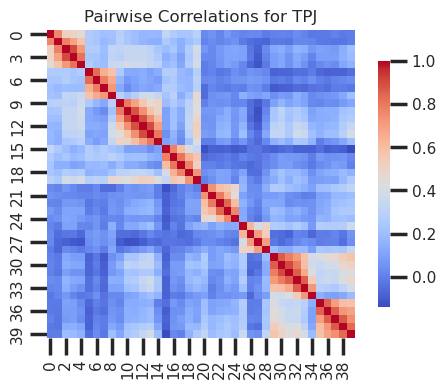

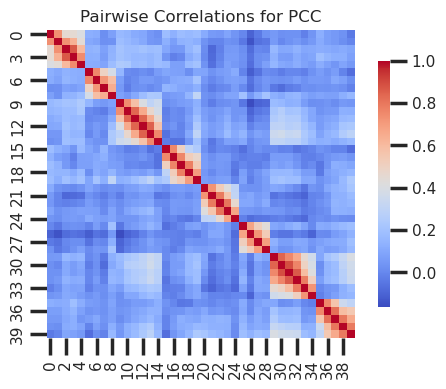

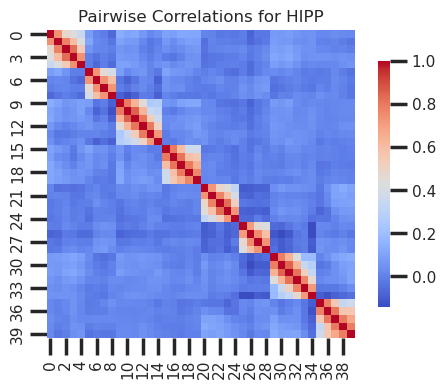

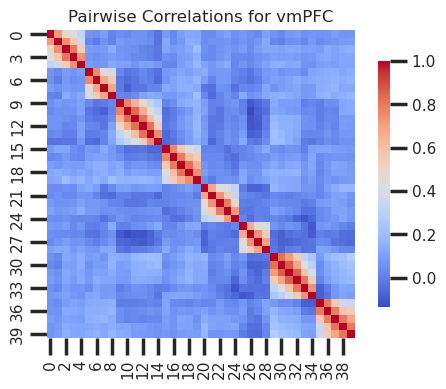

In [472]:
import matplotlib.pyplot as plt
import seaborn as sns

ROIs = {5:'TPJ', 19:'PCC', 28:'HIPP', 32:'vmPFC'}
for mask in [5,19,28,32]:
    roi = ROIs[mask]

    plt.figure(figsize=(6, 4))  # Adjust the size of the figure as needed
    sns.heatmap(between_correlation[mask], annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title(f'Pairwise Correlations for {roi}')
    plt.show()

### Check effect of on-diagonal 

In [ ]:

#Event level analysis 
# off-diagonal 값을 모으는 리스트 초기화
off_diagonal_values, on_diagonal_values = [], []
# on-diagonal 값을 모으는 리스트 초기화
on_diagonal_values = []

# 매트릭스의 모든 행과 열에 대해 반복하여 값을 모음
for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        if i == j:  # on-diagonal 값일 경우
            on_diagonal_values.append(matrix[i, j])
        else:  # off-diagonal 값일 경우
            off_diagonal_values.append(matrix[i, j])
            
# upper triangular matrix에서 off-diagonal 값을 모음
for i in range(len(matrix)):
    for j in range(i + 1, len(matrix[i])):  # upper triangular matrix의 상삼각 부분만 반복
        off_diagonal_values.append(matrix[i, j])
        

# 결과 출력
print("Off-diagonal 값들:")
print(off_diagonal_values)
print("\nOn-diagonal 값들:")
print(on_diagonal_values)


In [ ]:


# STORY MATRIXS
story = np.zeros((20, 20))
for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    story[start:end, start:end] = 0.5

story_upper = np.hstack((diagonal_mat,story))
story_under = np.hstack((story, diagonal_mat))
story_mat = np.vstack((story_upper,story_under))

for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    story_mat[start:end, start:end] = 1
    story_mat[start+20:end+20, start+20:end+20] = 1


# EVENT MATRIXS
event = np.zeros((20, 20)) 
for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    event[start:end, start:end] = 0
    for idx,loc in enumerate(story_boundary[whcihStory]):
        event[loc,loc] = event_score[whcihStory][idx]
event_upper = np.hstack((diagonal_mat,event))
event_under = np.hstack((event, diagonal_mat))
event_mat = np.vstack((event_upper,event_under)) 



# Story level analysis 

# 'variable' 딕셔너리 예시 데이터
variable = {
    'index_1': [5, 10, 15],
    'index_2': [20, 25, 30]
    # 이하 생략
}

# 'variable' 딕셔너리에 정보를 모을 리스트 초기화
collected_info = []

# 'variable' 딕셔너리의 각 키에 대해 반복하면서 매트릭스에서 해당 인덱스의 정보를 모음
for key, indices in variable.items():
    # 각 인덱스의 정보를 모음
    info = [matrix[i] for i in indices]
    # 모은 정보를 'variable' 딕셔너리에 추가
    variable[key] = info
    # collected_info 리스트에도 정보를 추가 (옵션)
    collected_info.extend(info)

# 결과 출력
print("변수 딕셔너리:")
print(variable)
# (옵션) 정보를 모은 리스트 출력
print("모은 정보 리스트:")
print(collected_info)





## BN networks

In [36]:
### Warning !! It takes much time .. almost 1 hours... ## BN masks
from scipy.stats import pearsonr
from tqdm import tqdm

output_dir = os.path.join(May_dir,'analysis', 'betas') 
mask_files = glob.glob(os.path.join(May_dir,'analysis', 'roi_masks', '*.nii.gz'))  

roi_masked_correlation = {} 
for mask in tqdm(range(len(mask_files))):
    mask_img = image.load_img(mask_files[mask])
    mask_data = mask_img.get_fdata()

    # Expanding mask dimensions to match beta_data
    expanded_mask_data = mask_data[:, :, :, np.newaxis]
    expanded_mask_data = np.repeat(expanded_mask_data, beta_data.shape[3], axis=3)

    sub_masked_correlation = {}
    for sub in subjects: 
        print(sub, 'load betas')
        beta_files = glob.glob(os.path.join(output_dir, f"sub-{sub}_task-encoding_run-*_betas_image.nii.gz"))  

        masked_beta_img ={}
        for run in np.arange(0,2):
            beta_imgs = image.load_img(beta_files[run])    
            beta_data = beta_imgs.get_fdata()
            masked_beta_data = beta_data * expanded_mask_data
            masked_beta_img[run] = image.new_img_like(beta_imgs, masked_beta_data)

        
        # Concat betas 
        concatenated_img = image.concat_imgs([masked_beta_img[0], masked_beta_img[1]])
        
        print('Start to calculate a correlation') 
        correlation = np.zeros((40, 40))
        for i in range(40):
            for j in range(40):
                data_i = concatenated_img.get_fdata()[:,:,:,i].ravel()
                data_j = concatenated_img.get_fdata()[:,:,:,j].ravel()
                correlation[i, j], _ = pearsonr(data_i, data_j)
        sub_masked_correlation[sub] = correlation
    roi_masked_correlation[mask] = sub_masked_correlation

2 load betas
Start to calculate a correlation
3 load betas
Start to calculate a correlation
4 load betas
Start to calculate a correlation
5 load betas
Start to calculate a correlation
6 load betas
Start to calculate a correlation
7 load betas
Start to calculate a correlation
8 load betas
Start to calculate a correlation
10 load betas
Start to calculate a correlation
11 load betas
Start to calculate a correlation
12 load betas
Start to calculate a correlation
13 load betas
Start to calculate a correlation
14 load betas
Start to calculate a correlation
15 load betas
Start to calculate a correlation
16 load betas
Start to calculate a correlation
17 load betas
Start to calculate a correlation
18 load betas
Start to calculate a correlation
19 load betas
Start to calculate a correlation
20 load betas
Start to calculate a correlation
21 load betas
Start to calculate a correlation
22 load betas
Start to calculate a correlation
23 load betas
Start to calculate a correlation
24 load betas
Start 

In [37]:
roi_correlation_distance= {}
for mask in range(len(mask_files)):
    correlations = roi_masked_correlation[mask]
    correlation_distance = np.array([correlations[sub] for sub in correlations])
    roi_correlation_distance[mask] = np.mean(correlation_distance, axis=0)

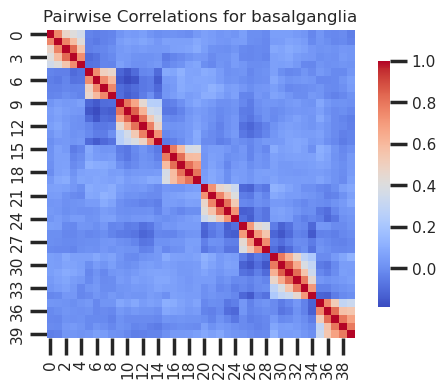

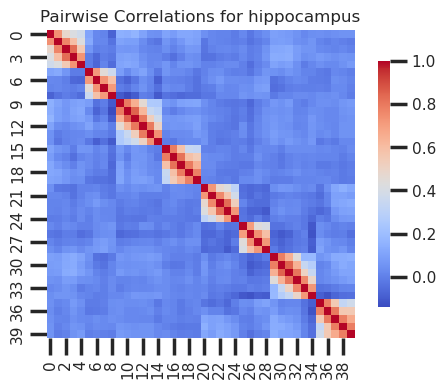

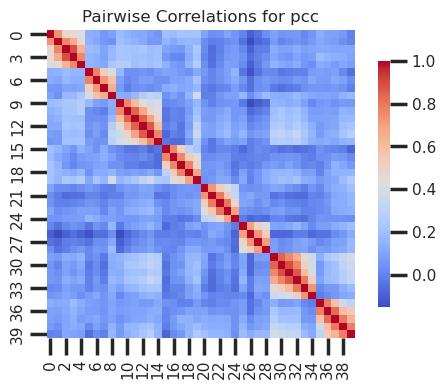

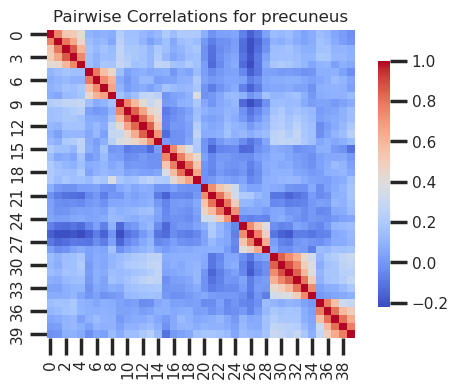

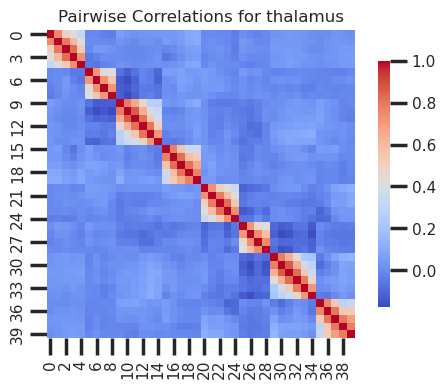

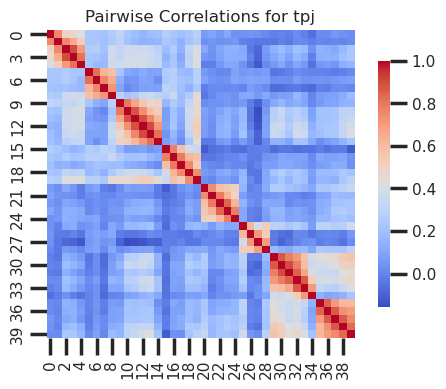

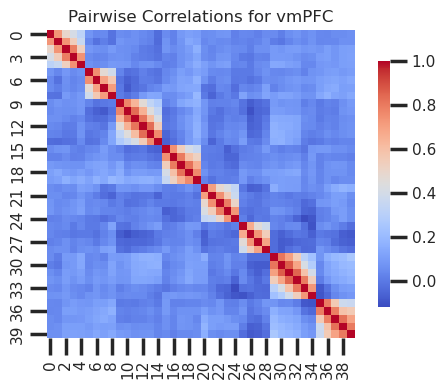

In [276]:
import matplotlib.pyplot as plt
import seaborn as sns

for mask in range(len(mask_files)):
    parts = mask_files[mask].split('_')
    roi = parts[3]

    plt.figure(figsize=(6, 4))  # Adjust the size of the figure as needed
    sns.heatmap(roi_correlation_distance[mask], annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title(f'Pairwise Correlations for {roi}')
    plt.show()

# RDM2

In [ ]:
# Load betas according to ROI mask 

# Get Correlation between run1 and run2, and Z-scorig within story ?

In [ ]:
# make 1d vectors 

In [ ]:
# Sorting Big-update and Small-update 

# Make Hypothesis matirces

In [630]:
# Define hypothesis matrices
stories = ['RunningMan', 'Dream', 'Blind','Neighbors'] 
story_boundary = {'Blind': range(5), 'Dream' : range(5,9), 'Neighbors' : range(9,15), 'RunningMan' : range(15,20)}

story_start = {'Blind': 0, 'Dream' : 5, 'Neighbors' : 9, 'RunningMan' : 15}
story_end = {'Blind': 5, 'Dream' : 9, 'Neighbors' : 15, 'RunningMan' : 20}
# event_score  = {'RunningMan': [1,1,1,1,1], 'Dream' : [1,0.5,0.5,1], 'Blind' : [0.5,0.5,1,1,0.5], 'Neighbors' : [0.5,0.5,0.5,0.5,1,1]}
event_score  = {'RunningMan': [1,1,1,1,1], 'Dream' : [1,0,0,1], 'Blind' : [0,0,1,1,0], 'Neighbors' : [0,0,0,0,1,1]}

diagonal_mat = np.zeros((20, 20))
for i in range(20):
    diagonal_mat[i,i] = 1 

# EPISODIC MATRIXS
episodic_mat = np.zeros((40, 40)) 
for i in range(40):
    episodic_mat[i,i] = 1

    
story_only_mat =  np.zeros((40, 40))   
for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    story_only_mat[start:end, start:end] = 1
    story_only_mat[start+20:end+20, start+20:end+20] = 1
    

# STORY MATRIXS
story = np.zeros((20, 20))
for whcihStory in stories: 
    # for loc in story_boundary[whcihStory]:
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    story[start:end, start:end] = 0.5
        # story[loc,loc] = 1
story_upper = np.hstack((diagonal_mat,story))
story_under = np.hstack((story, diagonal_mat))
story_mat = np.vstack((story_upper,story_under))

for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    story_mat[start:end, start:end] = 1
    story_mat[start+20:end+20, start+20:end+20] = 1


# EVENT MATRIXS
event = np.zeros((20, 20)) 
for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    event[start:end, start:end] = 0
    for idx,loc in enumerate(story_boundary[whcihStory]):
        event[loc,loc] = 1
event_upper = np.hstack((diagonal_mat,event))
event_under = np.hstack((event, diagonal_mat))
event_mat = np.vstack((event_upper,event_under)) 
for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    event_mat[start:end, start:end] = 1
    event_mat[start+20:end+20, start+20:end+20] = 1

#story update Matirx 
Update_story =  np.zeros((20, 20))
for whcihStory in stories: 
    # for loc in story_boundary[whcihStory]:
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    if whcihStory == 'RunningMan':
        Update_story[start:end, start:end] = 1
    elif whcihStory == 'Dream':
        Update_story[start:end, start:end] = 0.5
    else:
        Update_story[start:end, start:end] = 0.4
    
        # story[loc,loc] = 1
Updated_story_upper = np.hstack((diagonal_mat,Update_story))
Updated_story_under = np.hstack((Update_story, diagonal_mat))
Updated_story_mat = np.vstack((Updated_story_upper,Updated_story_under))

for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    Updated_story_mat[start:end, start:end] = 1
    Updated_story_mat[start+20:end+20, start+20:end+20] = 1


# hiearchy MATRIXS
hiearchy = np.zeros((20, 20))
for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]    
    hiearchy[start:end, start:end] = 0.5
    for idx,loc in enumerate(story_boundary[whcihStory]):
        hiearchy[loc,loc] = event_score[whcihStory][idx]
        
hiearchy_upper = np.hstack((diagonal_mat,hiearchy))
hiearchy_under = np.hstack((hiearchy, diagonal_mat))
hiearchy_mat = np.vstack((hiearchy_upper,hiearchy_under)) 
for i in range(40):
    hiearchy_mat[i,i] = 1
for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    hiearchy_mat[start:end, start:end] = 1
    hiearchy_mat[start+20:end+20, start+20:end+20] = 1
    
    
# eventHiearchy MATRIXS
eventHiearchy = np.zeros((20, 20))
for whcihStory in stories: 
    for idx,loc in enumerate(story_boundary[whcihStory]):
        eventHiearchy[loc,loc] = event_score[whcihStory][idx]
eventHiearchy_upper = np.hstack((diagonal_mat,eventHiearchy))
eventHiearchy_under = np.hstack((eventHiearchy, diagonal_mat))
eventHiearchy_mat = np.vstack((eventHiearchy_upper,eventHiearchy_under)) 
for i in range(40):
    eventHiearchy_mat[i,i] = 1
for whcihStory in stories: 
    start = story_start[whcihStory]
    end = story_end[whcihStory]
    eventHiearchy_mat[start:end, start:end] = 1
    eventHiearchy_mat[start+20:end+20, start+20:end+20] = 1


# # DETAIL MATRIXS
# detail = np.zeros((20, 20))
# for whcihStory in stories: 
#     start = story_start[whcihStory]
#     end = story_end[whcihStory]
#     detail[start:end, start:end] = 0
#     for idx, loc in enumerate(story_boundary[whcihStory]):
#         detail[loc,loc] =detail_score[whcihStory][idx]
# detail_upper = np.hstack((diagonal_mat,detail))
# detail_under = np.hstack((detail, diagonal_mat))
# detail_mat = np.vstack((detail_upper,detail_under))  

# #DETAIL*EVENT MATRIXS
# detailEvent = np.zeros((20, 20))
# for whcihStory in stories: 
#     start = story_start[whcihStory]
#     end = story_end[whcihStory]
#     detailEvent[start:end, start:end] = 0
#     for idx, loc in enumerate(story_boundary[whcihStory]):
#         detailEvent[loc,loc] = (detail_score[whcihStory][idx]+0.1) * (event_score[whcihStory][idx]+0.1)
# detailEvent_upper = np.hstack((diagonal_mat,detailEvent))
# detailEvent_under = np.hstack((detailEvent, diagonal_mat))
# detailEvent_mat = np.vstack((detailEvent_upper,detailEvent_under))

# for whcihStory in stories: 
#     start = story_start[whcihStory]
#     end = story_end[whcihStory]
#     detailEvent_mat[start:end, start:end] = 0.3
#     detailEvent_mat[start+20:end+20, start+20:end+20] = 0.3


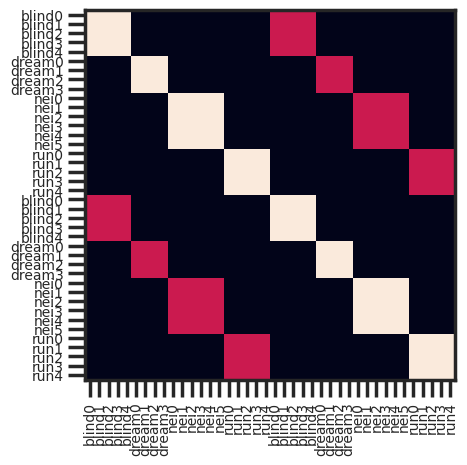

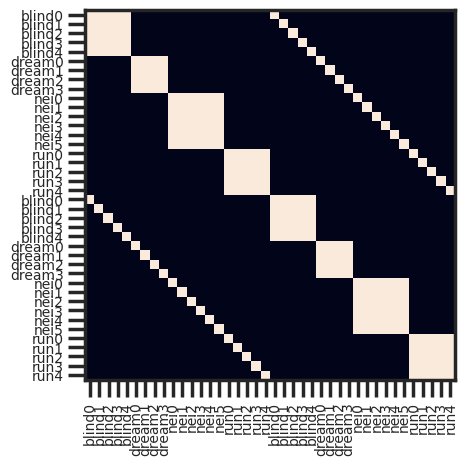

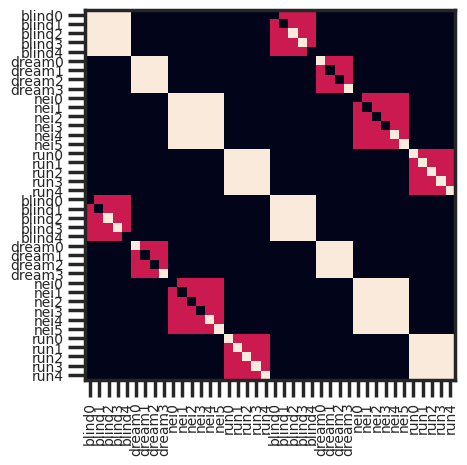

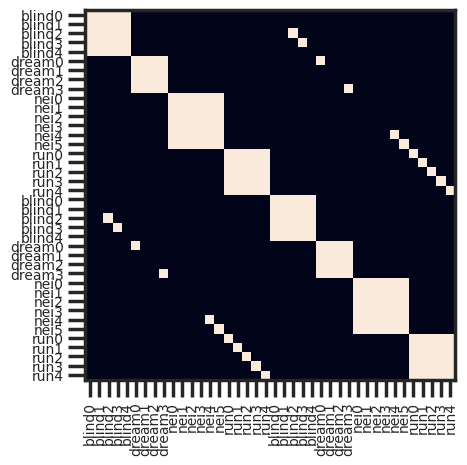

In [631]:
x_lab =['blind0', 'blind1', 'blind2', 'blind3', 'blind4', 'dream0',
       'dream1', 'dream2', 'dream3', 'nei0', 'nei1', 'nei2', 'nei3',
       'nei4', 'nei5', 'run0', 'run1', 'run2', 'run3', 'run4', 'blind0', 'blind1', 'blind2', 'blind3', 'blind4', 'dream0',
       'dream1', 'dream2', 'dream3', 'nei0', 'nei1', 'nei2', 'nei3',
       'nei4', 'nei5', 'run0', 'run1', 'run2', 'run3', 'run4']
y_lab =['blind0', 'blind1', 'blind2', 'blind3', 'blind4', 'dream0',
       'dream1', 'dream2', 'dream3', 'nei0', 'nei1', 'nei2', 'nei3',
       'nei4', 'nei5', 'run0', 'run1', 'run2', 'run3', 'run4', 'blind0', 'blind1', 'blind2', 'blind3', 'blind4', 'dream0',
       'dream1', 'dream2', 'dream3', 'nei0', 'nei1', 'nei2', 'nei3',
       'nei4', 'nei5', 'run0', 'run1', 'run2', 'run3', 'run4']
# plot model matrices (uncomment if desired) #

size = 10 
angle = 90 

# plt.imshow(episodic_mat)
# plt.xticks(range(len(x_lab)), x_lab, fontsize=size, rotation=angle)
# plt.yticks(range(len(y_lab)), y_lab, fontsize=size)
# plt.show()

# plt.imshow(story_only_mat)
# plt.xticks(range(len(x_lab)), x_lab, fontsize=size, rotation=angle)
# plt.yticks(range(len(y_lab)), y_lab, fontsize=size)
# plt.show()


plt.imshow(story_mat)
plt.xticks(range(len(x_lab)), x_lab, fontsize=size, rotation=angle)
plt.yticks(range(len(y_lab)), y_lab, fontsize=size)
plt.show()

plt.imshow(event_mat)
plt.xticks(range(len(x_lab)), x_lab, fontsize=size, rotation=angle)
plt.yticks(range(len(y_lab)), y_lab, fontsize=size)
plt.show()

# plt.imshow(Updated_story_mat)
# plt.xticks(range(len(x_lab)), x_lab, fontsize=size, rotation=angle)
# plt.yticks(range(len(y_lab)), y_lab, fontsize=size)
# plt.show()


plt.imshow(hiearchy_mat)
plt.xticks(range(len(x_lab)), x_lab, fontsize=size, rotation=angle)
plt.yticks(range(len(y_lab)), y_lab, fontsize=size)
plt.show()

plt.imshow(eventHiearchy_mat)
plt.xticks(range(len(x_lab)), x_lab, fontsize=size, rotation=angle)
plt.yticks(range(len(y_lab)), y_lab, fontsize=size)
plt.show()

# plt.imshow(detailEvent_mat)
# plt.xticks(range(len(x_lab)), x_lab, fontsize=size, rotation=angle)
# plt.yticks(range(len(y_lab)), y_lab, fontsize=size)
# plt.show()

## Model fitting 

In [632]:
from scipy.stats import pointbiserialr

upper_triangle_indices = np.triu_indices(40, k=1)

# flatten beta and hypothesis mat in to vectors 
hypotheses = {'episodic':episodic_mat, 'story': story_mat, 'story_only_mat':story_only_mat,  'updated_story': Updated_story_mat, 'event': event_mat, 'eventHiearchy_mat' : eventHiearchy_mat, 'hiearchy': hiearchy_mat}
conditions= ['event','story', 'hiearchy','eventHiearchy_mat']


flatten_hyp = {}
for cond in conditions:
    matrix = hypotheses[cond][upper_triangle_indices]
    flatten_hyp[cond] = matrix.flatten()
    
    
flatten_betas = {} 
#for mask in range(len(mask_files)):
for mask in [5,19,28,32]:
    sub_flatten_betas = {} 
    for sub in subjects: 
        matrix = roi_concated_correlation[mask][sub][upper_triangle_indices]
        sub_flatten_betas[sub] = matrix.flatten()
    flatten_betas[mask]  = sub_flatten_betas
    

# Compute the Pearson correlation between the two vectors
# Isolate the z-scored correlation coefficients and make lists
roi_mat_corrs, roi_mat_p_vals = {},{} 
#for mask in range(len(mask_files)):
for mask in [5,19,28,32]:
    cond_mat_corrs, cond_mat_p_vals  = {},{} 
    for cond in conditions:
        mat_corrs, mat_p_val = [] , [] 
        for sub in subjects: 
            corr, p_val = pointbiserialr(flatten_betas[mask][sub],flatten_hyp[cond])
            mat_corrs.append(corr)
            mat_p_val.append(p_val)
        cond_mat_corrs[cond] = mat_corrs
        cond_mat_p_vals[cond] = mat_p_val
    roi_mat_corrs[mask] = cond_mat_corrs
    roi_mat_p_vals[mask] = cond_mat_p_vals


In [633]:
# Create a dataframe of the lists
import statsmodels.stats.multicomp as mc
from statsmodels.stats.anova import AnovaRM



roi_corr_df = {} 
AOVs = {} 
comps = {} 
#for mask in range(len(mask_files)):
for mask in [5,19,28,32]:
    corr_df = pd.DataFrame(list(zip(roi_mat_corrs[mask]['event'],
                                    #roi_mat_corrs[mask]['story_only_mat'],
                                    roi_mat_corrs[mask]['story'],
                                    #roi_mat_corrs[mask]['updated_story'],
                                    roi_mat_corrs[mask]['eventHiearchy_mat'],
                                    roi_mat_corrs[mask]['hiearchy'] )), 
                           columns=(['event', 'story', 'eventHiearchy_mat','hiearchy']))

    # Convert to a 'long' format dataframe for 1-way ANOVA
    corr_df_stacked = corr_df.stack().reset_index()
    corr_df_stacked.columns = ['subject','model','zscore']
    roi_corr_df[mask] = corr_df_stacked
    
    # One-way repeated-measures ANOVA
    AOV = AnovaRM(data=corr_df_stacked, depvar='zscore', subject='subject', within=['model']).fit()
    AOVs[mask] = AOV
    print(mask, AOV)
    
    # One-way repeated-measures ANOVA
    comp = mc.MultiComparison(corr_df_stacked['zscore'], corr_df_stacked['model'])
    post_hoc_res = comp.tukeyhsd()
    comps[mask] =post_hoc_res
    print(post_hoc_res.summary())


5                Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
model 33.2942 3.0000 87.0000 0.0000

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
            event eventHiearchy_mat   0.0225  0.465 -0.0177  0.0627  False
            event          hiearchy  -0.0313 0.1831 -0.0715  0.0089  False
            event             story  -0.0168 0.6989  -0.057  0.0235  False
eventHiearchy_mat          hiearchy  -0.0538 0.0038 -0.0941 -0.0136   True
eventHiearchy_mat             story  -0.0393 0.0582 -0.0795  0.0009  False
         hiearchy             story   0.0146 0.7812 -0.0257  0.0548  False
--------------------------------------------------------------------------
19                Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
model 21.6537 3.0000 8

In [634]:
roi_corr_df[5]['roi'] = 'tpj'
roi_corr_df[19]['roi'] = 'pcc'
roi_corr_df[28]['roi'] = 'HPC'
roi_corr_df[32]['roi'] = 'vmPFC'

roi_corr_df_concat_all = pd.concat([roi_corr_df[5], roi_corr_df[19], roi_corr_df[28],roi_corr_df[32]])


Text(0, 0.5, 'Model fit (z-score)')

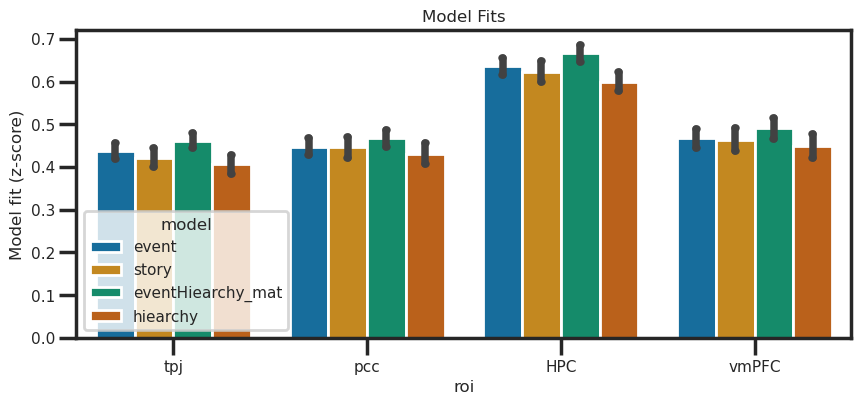

In [635]:
# #BARPLOT VERSION
# import seaborn as sns


# #for mask in range(len(mask_files)):
# for mask in [5,19,28,32]:
#     #parts = mask_files[mask].split('_')
#     roi = ROIs[mask]
    
#     sns.set(style="ticks",context=("poster"),font_scale=0.5)
#     fig, ax = plt.subplots()
#     fig.set_size_inches(8,8)
#     #ax.set_ylim(0.0,0.09)
#     mat = roi_corr_df[mask]
#     fig = sns.barplot(x="model", y='zscore', data=mat, capsize=.01, ci=68, palette="colorblind")
#     fig = sns.swarmplot(x="model", y='zscore', dodge=True, data=mat, size=4, color="k", alpha=.5)
#     #leg = fig.axes.flat[0].get_legend()
#     plt.title(f"Model Fits of {roi}")
#     plt.ylabel("Model fit (z-score)")
#     #plt.xlabel("Model")
#     plt.tight_layout()
#     #ax.legend_.remove()
#     #plt.savefig('mPFC_model_matrix_fits.pdf')
    
    
    
#BARPLOT VERSION
import seaborn as sns


# #for mask in range(len(mask_files)):
# for loc, mask in enumerate([5,19,28,32]):
#     #parts = mask_files[mask].split('_')
#     roi = ROIs[mask]
    
sns.set(style="ticks",context=("poster"),font_scale=0.5)
fig, ax = plt.subplots(figsize = (10, 4),sharey=True)   
#ax.set_ylim(0.0,0.09)
# mat = roi_corr_df[mask]
fig = sns.barplot(x="roi", y='zscore', hue= 'model', data=roi_corr_df_concat_all, capsize=.005, ci=95, palette="colorblind")
#fig = sns.swarmplot(x="roi", y='zscore',dodge=True, data=roi_corr_df_concat_all, size=1.5, color="k", alpha=.5)
#fig.axes.get_legend()
plt.title(f"Model Fits")
plt.ylabel("Model fit (z-score)")
#plt.xlabel("Model")
#plt.tight_layout()
#ax.legend_.remove()
#plt.savefig('mPFC_model_matrix_fits.pdf')


In [175]:
# Compare all subjects a
from scipy.stats import pointbiserialr

# flatten beta and hypothesis mat in to vectors 
hypotheses = {'episodic':episodic_mat, 'story': story_mat, 'event': event_mat, 'detail': detail_mat, 'eventdetail': detailEvent_mat}
conditions= ['episodic','story', 'event','detail','eventdetail']


flatten_hyp = {}
for cond in conditions:
    matrix = hypotheses[cond] 
    flatten_hyp[cond] = matrix.flatten()
    
    
flatten_betas = {} 
for mask in range(len(mask_files)):
    flatten_betas[mask]  = roi_correlation_distance[mask].flatten()
    

# Compute the Pearson correlation between the two vectors
for mask in range(len(mask_files)):
    parts = mask_files[mask].split('_')
    roi = parts[3]
    
    for cond in conditions:
        print(roi, cond)
        print(pointbiserialr(flatten_betas[mask],flatten_hyp[cond]))


basalganglia episodic
PointbiserialrResult(correlation=0.6079640193389919, pvalue=2.500031459461784e-162)
basalganglia story
PointbiserialrResult(correlation=0.1623829262305837, pvalue=6.418619365031225e-11)
basalganglia event
PointbiserialrResult(correlation=0.46443087750881407, pvalue=2.1145747511142513e-86)
basalganglia detail
PointbiserialrResult(correlation=0.43472737484984003, pvalue=9.409215067149426e-75)
basalganglia eventdetail
PointbiserialrResult(correlation=0.44159637400021257, pvalue=2.4081401365244755e-77)
hippocampus episodic
PointbiserialrResult(correlation=0.6147125342782005, pvalue=6.624659429924401e-167)
hippocampus story
PointbiserialrResult(correlation=0.14420179174778813, pvalue=6.878282305176938e-09)
hippocampus event
PointbiserialrResult(correlation=0.4652296424542321, pvalue=9.903393053612013e-87)
hippocampus detail
PointbiserialrResult(correlation=0.43429416970698986, pvalue=1.3646494146394112e-74)
hippocampus eventdetail
PointbiserialrResult(correlation=0.442